# **Advanced Machine Learning: EasyVisa - Solution Notebook**



---



## **Problem Statement**

### **Context:**

Business communities in the United States are facing high demand for human resources, but one of the constant challenges is identifying and attracting the right talent, which is perhaps the most important element in remaining competitive. Companies in the United States look for hard-working, talented, and qualified individuals both locally as well as abroad.

The Immigration and Nationality Act (INA) of the US permits foreign workers to come to the United States to work on either a temporary or permanent basis. The act also protects US workers against adverse impacts on their wages or working conditions by ensuring US employers' compliance with statutory requirements when they hire foreign workers to fill workforce shortages. The immigration programs are administered by the Office of Foreign Labor Certification (OFLC).

OFLC processes job certification applications for employers seeking to bring foreign workers into the United States and grants certifications in those cases where employers can demonstrate that there are not sufficient US workers available to perform the work at wages that meet or exceed the wage paid for the occupation in the area of intended employment.

### **Objective:**

In 2016, the OFLC handled over 775,000 job applications for nearly 1.7 million positions. This was 9% more than the year before, and reviewing each case has become a slow and difficult task.

To make the process faster, the OFLC hired EasyVisa to use machine learning. As a data scientist at EasyVisa, our job is to:

* Help speed up visa approval decisions
* Predict which applicants are more likely to be approved or denied based on important data

### **Data Dictionary:**

The data contains the different attributes of the employee and the employer. The detailed data dictionary is given below.

* case_id: ID of each visa application
* continent: Information of continent the employee
* education_of_employee: Information of education of the employee
* has_job_experience: Does the employee has any job experience? Y = Yes; N = No
* requires_job_training: Does the employee require any job training? Y = Yes; N = No
* no_of_employees: Number of employees in the employer's company
* yr_of_estab: Year in which the employer’s company was established
* region_of_employment: Information of foreign worker’s intended region of employment in the US
* prevailing_wage: Average wage paid to similarly employed workers in a specific occupation in the area of intended employment. The purpose of the prevailing wage is to ensure that the foreign worker is not underpaid compared to other workers offering the same or similar service in the same area of employment.
* unit_of_wage: Unit of prevailing wage. Values include Hourly, Weekly, Monthly, and Yearly.
* full_time_position: Is the position of work full-time? Y = Full-Time Position; N = Part-Time Position
* case_status: Flag indicating if the Visa was certified or denied



---



## **Let us start by importing the required libraries**

In [11]:
# To install XGBoost Library
!pip install xgboost

In [12]:
# To load and manipulate data
import numpy as np
import pandas as pd

# To visualize the data
import matplotlib.pyplot as plt
import seaborn as sns

# Command to display the graphs
%matplotlib inline

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)

# To split the data into training and testing sets
from sklearn.model_selection import train_test_split

from sklearn import metrics

# To compute classification metrics
from sklearn.metrics import(confusion_matrix, accuracy_score, precision_score, recall_score, f1_score)

# To ignore unnecessary warnings
import warnings
warnings.filterwarnings("ignore")

# To help with model building
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# To do hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

# To tune different models
from sklearn.model_selection import GridSearchCV

# For encoding categorical variables
from sklearn.preprocessing import LabelEncoder, OneHotEncoder



---



## **Loading the Dataset**

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
# To read the dataset from google drive
visa_approval = pd.read_csv("/content/drive/My Drive/Colab Notebooks/EasyVisa.csv")

In [15]:
# creating a copy of the data
data = visa_approval.copy()

**Observations:**

* The EasyVisa.csv dataset has been successfully loaded and stored in the variable visa_approval. A copy of this dataset has been created and saved as data, which will be used for our model building exercise.



---



## **Data Overview**

### **Viewing the first 5 rows and last 5 rows of the dataset**

In [16]:
data.head(5)

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied
3,EZYV04,Asia,Bachelor's,N,N,98,1897,West,83434.0300,Year,Y,Denied
4,EZYV05,Africa,Master's,Y,N,1082,2005,South,149907.3900,Year,Y,Certified


In [17]:
data.tail(5)

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
25475,EZYV25476,Asia,Bachelor's,Y,Y,2601,2008,South,77092.57,Year,Y,Certified
25476,EZYV25477,Asia,High School,Y,N,3274,2006,Northeast,279174.79,Year,Y,Certified
25477,EZYV25478,Asia,Master's,Y,N,1121,1910,South,146298.85,Year,N,Certified
25478,EZYV25479,Asia,Master's,Y,Y,1918,1887,West,86154.77,Year,Y,Certified
25479,EZYV25480,Asia,Bachelor's,Y,N,3195,1960,Midwest,70876.91,Year,Y,Certified


**Observations**:

* The case_id column is just a unique identifier and does not help in prediction. It can be dropped from the dataset.

* The unit_of_wage column contains multiple wage units like Hour, Week, Month, and Year. These need to be standardized to a single unit (yearly) for consistency.

* The prevailing_wage column needs to be adjusted based on the unit_of_wage to represent an annual wage for uniform comparison.

* Categorical columns such as continent, education_of_employee, and region_of_employment contain string values and should be converted to numeric using one-hot encoding.

* Binary columns like has_job_experience, requires_job_training, full_time_position, and case_status have "Y" and "N" values and should be label encoded to 1 and 0.

* The yr_of_estab column can be used to calculate a more useful feature called company_age by subtracting it from the current year (2025).

* The target column is case_status, which indicates whether the visa application was Certified or Denied.


---



### **Checking the shape of the dataset**

In [18]:
data.shape

(25480, 12)

**Observations**:

* The dataset contains 25480 rows and 12 columns.



---



### **Checking the attribute types**

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   case_id                25480 non-null  object 
 1   continent              25480 non-null  object 
 2   education_of_employee  25480 non-null  object 
 3   has_job_experience     25480 non-null  object 
 4   requires_job_training  25480 non-null  object 
 5   no_of_employees        25480 non-null  int64  
 6   yr_of_estab            25480 non-null  int64  
 7   region_of_employment   25480 non-null  object 
 8   prevailing_wage        25480 non-null  float64
 9   unit_of_wage           25480 non-null  object 
 10  full_time_position     25480 non-null  object 
 11  case_status            25480 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 2.3+ MB


**Observations:**
* Many columns are of type object i.e. strings. These need to be converted to categorical type.
* The output shows no missing values in the dataset.



---



In [20]:
# To convert all object-type (string) columns to categorical type for better memory usage
for feature in data.columns:
  if data[feature].dtype == 'object':
    data[feature] = pd.Categorical(data[feature])

# Display the first 3 rows of the updated dataset
data.head(3)

,case_id,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,EZYV01,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,EZYV02,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified
2,EZYV03,Asia,Bachelor's,N,Y,44444,2008,West,122996.8600,Year,Y,Denied


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   case_id                25480 non-null  category
 1   continent              25480 non-null  category
 2   education_of_employee  25480 non-null  category
 3   has_job_experience     25480 non-null  category
 4   requires_job_training  25480 non-null  category
 5   no_of_employees        25480 non-null  int64   
 6   yr_of_estab            25480 non-null  int64   
 7   region_of_employment   25480 non-null  category
 8   prevailing_wage        25480 non-null  float64 
 9   unit_of_wage           25480 non-null  category
 10  full_time_position     25480 non-null  category
 11  case_status            25480 non-null  category
dtypes: category(9), float64(1), int64(2)
memory usage: 2.0 MB


**Obesrvations:**

* All 9 object-type columns have been successfully converted to categorical dtype.



---



### **Checking the statistical summary**

In [22]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
no_of_employees,25480.0,5667.043210,22877.928848,-26.0000,1022.00,2109.00,3504.0000,602069.00
yr_of_estab,25480.0,1979.409929,42.366929,1800.0000,1976.00,1997.00,2005.0000,2016.00
prevailing_wage,25480.0,74455.814592,52815.942327,2.1367,34015.48,70308.21,107735.5125,319210.27


**Observations:**

* The no_of_employees column has a minimum value of -26, which is not logical. The number of employees cannot be negative. This needs to be investigated and corrected.

* The yr_of_estab column ranges from 1800 to 2016. Rather than using the raw year, it would be more meaningful to create a company_age feature by subtracting yr_of_estab from 2025.

* The prevailing_wage column should be standardized to annual salary, as the current wages are given in different units (Hour, Week, Month, Year). Converting all wages to per annum will make the data consistent for comparison and modeling.



---




### **Checking for missing values**

In [23]:
data.isnull().sum()

,0
case_id,0
continent,0
education_of_employee,0
has_job_experience,0
requires_job_training,0
no_of_employees,0
yr_of_estab,0
region_of_employment,0
prevailing_wage,0
unit_of_wage,0


**Observations**:
* There are no missing values in any of the columns.



---



### **Checking for duplicate values**

In [24]:
data.duplicated().sum()

np.int64(0)

**Observations:**
* There are no duplicate values in the dataset.


---



### **Checking the value counts for categorical columns**

In [25]:
for column in data.columns:
    if data[column].dtype.name == 'category':
        print(f"Value counts for '{column}':")
        counts = data[column].value_counts()
        percentages = data[column].value_counts(normalize=True) * 100
        result = pd.DataFrame({'Count': counts, 'Percentage (%)': percentages.round(2)})
        print(result)
        print("-" * 50)

Value counts for 'case_id':
           Count  Percentage (%)
case_id                         
EZYV9999       1             0.0
EZYV01         1             0.0
EZYV02         1             0.0
EZYV03         1             0.0
EZYV04         1             0.0
...          ...             ...
EZYV10000      1             0.0
EZYV1000       1             0.0
EZYV100        1             0.0
EZYV10         1             0.0
EZYV09         1             0.0

[25480 rows x 2 columns]
--------------------------------------------------
Value counts for 'continent':
               Count  Percentage (%)
continent                           
Asia           16861           66.17
Europe          3732           14.65
North America   3292           12.92
South America    852            3.34
Africa           551            2.16
Oceania          192            0.75
--------------------------------------------------
Value counts for 'education_of_employee':
                       Count  Percentage (%)
ed

**Observations**:

* Continent: Most applicants are from Asia, followed by Europe and North America. Other continents have much fewer applicants.

* Education: The majority of applicants hold a Bachelor’s or Master’s degree. Fewer have a High School or Doctorate degree.

* Job Experience: Around 58% of applicants have job experience, which might positively influence approval.

* Job Training: Most applicants do not require training (only ~12% need training).

* Region of Employment: Applications are mostly for Northeast, South, and West US regions.

* Unit of Wage: Most wages are given in Yearly format. Others like Hourly, Weekly, and Monthly need to be standardized to yearly.

* Full-Time Position: Most job offers are for full-time positions (89%).

* Case Status: The dataset is imbalanced — around 67% Certified and 33% Denied, so class balancing techniques needs to be implemented.



---



## **Data Cleaning**

**Data Cleaning – To Do List:**

1. Drop the case_id column after confirming all values are unique, as it doesn’t help in model training.

2. Check for negative values in the no_of_employees column and fix them, since employee count cannot be negative.

3. Create a new column called company_age by subtracting yr_of_estab from 2025.

4. Convert all values in the prevailing_wage column to yearly wage using the unit_of_wage column for consistency.

### **1. Dropping column with all unique values**

In [26]:
# Checking the number of unique values in each column
data.nunique()

,0
case_id,25480
continent,6
education_of_employee,4
has_job_experience,2
requires_job_training,2
no_of_employees,7105
yr_of_estab,199
region_of_employment,5
prevailing_wage,25454
unit_of_wage,4


In [27]:
# Dropping Case_id column as it has only unique values and doesn't provied any value to our model building
data = data.drop(columns='case_id')

In [28]:
data.head(2)

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
0,Asia,High School,N,N,14513,2007,West,592.2029,Hour,Y,Denied
1,Asia,Master's,Y,N,2412,2002,Northeast,83425.6500,Year,Y,Certified


**Observations:**

* The case_id column was found to have all unique values and does not provide any useful information for prediction, it was dropped from the dataset.



---



### **2. Checking no_of_employees column**

In [29]:
data[data['no_of_employees'] < 0].head(4)

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status
245,Europe,Master's,N,N,-25,1980,Northeast,39452.99,Year,Y,Certified
378,Asia,Bachelor's,N,Y,-11,2011,Northeast,32506.14,Year,Y,Denied
832,South America,Master's,Y,N,-17,2002,South,129701.94,Year,Y,Certified
2918,Asia,Master's,Y,N,-26,2005,Midwest,112799.46,Year,Y,Certified


In [30]:
data[data['no_of_employees'] < 0].shape

(33, 11)

* There are 33 rows with negative values in the no_of_employees column. This seems to be a data entry mistake (a misplaced negative sign). These values can be converted to positive using .abs() to ensure logical consistency.

In [31]:
# Fix negative values by taking absolute value
data['no_of_employees'] = data['no_of_employees'].abs()

In [32]:
data[data['no_of_employees'] < 0]


,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,unit_of_wage,full_time_position,case_status


**Observations**:

* All negative values were corrected by converting them to positive using .abs().

* After applying the fix, there are no more negative values in the no_of_employees column.



---



### **4. Checking prevailing_wage column**

In [34]:
data['unit_of_wage'].value_counts()

,count
unit_of_wage,
Year,22962
Hour,2157
Week,272
Month,89


In [35]:
# Convert wage values to annual in the same column
data.loc[data['unit_of_wage'] == 'Hour', 'prevailing_wage'] *= 40 * 52
data.loc[data['unit_of_wage'] == 'Week', 'prevailing_wage'] *= 52
data.loc[data['unit_of_wage'] == 'Month', 'prevailing_wage'] *= 12

In [36]:
data = data.drop(columns='unit_of_wage')

In [37]:
data.head(3)

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,yr_of_estab,region_of_employment,prevailing_wage,full_time_position,case_status
0,Asia,High School,N,N,14513,2007,West,1231782.032,Y,Denied
1,Asia,Master's,Y,N,2412,2002,Northeast,83425.650,Y,Certified
2,Asia,Bachelor's,N,Y,44444,2008,West,122996.860,Y,Denied


**Observations:**

* To maintain consistency, all values in the prevailing_wage column were converted to an annual (yearly) wage using appropriate multipliers.

* After standardizing, the unit_of_wage column was dropped as it is no longer needed.



---





### **3. Checking yr_of_estab column**

In [38]:
# Creating a new column 'age_company' by subtracting year of establishment from 2025 - This gives the age of the company, which is more meaningful than the raw year
data['age_company'] = 2025 - data['yr_of_estab']

# Dropping the original 'yr_of_estab' column as it's now replaced by 'age_company'
data = data.drop(columns='yr_of_estab')

In [39]:
data.head(2)

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,region_of_employment,prevailing_wage,full_time_position,case_status,age_company
0,Asia,High School,N,N,14513,West,1231782.032,Y,Denied,18
1,Asia,Master's,Y,N,2412,Northeast,83425.650,Y,Certified,23


**Observations:**

* A new column called age_company (yrs) was created by subtracting the yr_of_estab from 2025.

* The conversion helps the model better understand the experience or maturity of the company, which may influence visa approvals.



---



## **Exploratory Data Analysis**

## **Univariate Analysis**

I'll begin by classifying the columns into numerical, binary, and categorical types for better analysis:

**Numerical** → no_of_employees, prevailing_wage, age_company

**Categorical** → continen, education_of_employee, region_of_employment, case_status

**Binary** → has_job_experience, requires_job_training, full_time_position



---



#### **Numerical Columns**

In [40]:
# Defining the list of numerical columns
num_columns = ['no_of_employees', 'prevailing_wage', 'age_company']

In [41]:
# Descriptive statistics
data[num_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
no_of_employees,25480.0,5667.089207,22877.917453,11.0,1022.000,2109.00,3504.000,602069.0
prevailing_wage,25480.0,197391.155259,578591.666314,100.0,47107.965,82839.46,124825.035,14569149.4
age_company,25480.0,45.590071,42.366929,9.0,20.000,28.00,49.000,225.0


**Observations:**

* Most companies have less than 3,500 workers, but a few very big companies have more than 600,000 workers. This makes the data go very high on one side.

* The average salary is about \$197,000 but the median is much lower at \$82,839. This means a few very high salaries increase the average.

* The average company age is about 46 years, and most companies are between 20 to 50 years old. Some are even over 200 years old.

**1. Number of Employees**

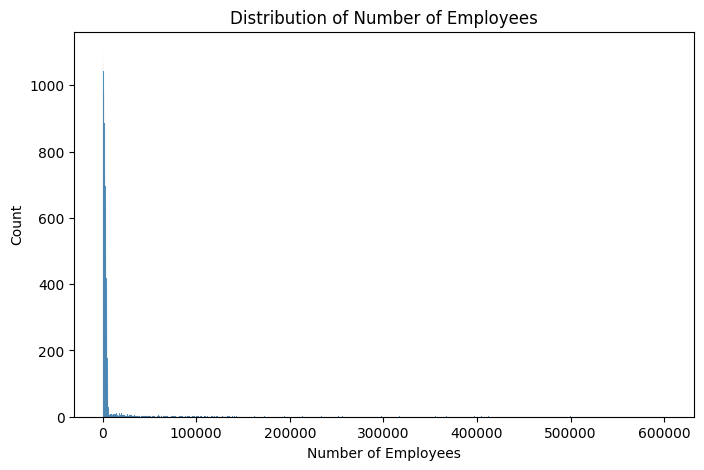

In [42]:
# Plotting histogram for no_of_employees column
plt.figure(figsize=(8, 5))
sns.histplot(data=data, x='no_of_employees', kde=False)
plt.xlabel('Number of Employees')
plt.ylabel('Count')
plt.title('Distribution of Number of Employees')
plt.show()

* The distribution is heavily right-skewed.

* Most companies have very few employees, and only a few have extremely large counts (up to 500,000+).

* Focus on values below a threshold (less than 10,000 employees) to better visualize the distribution.

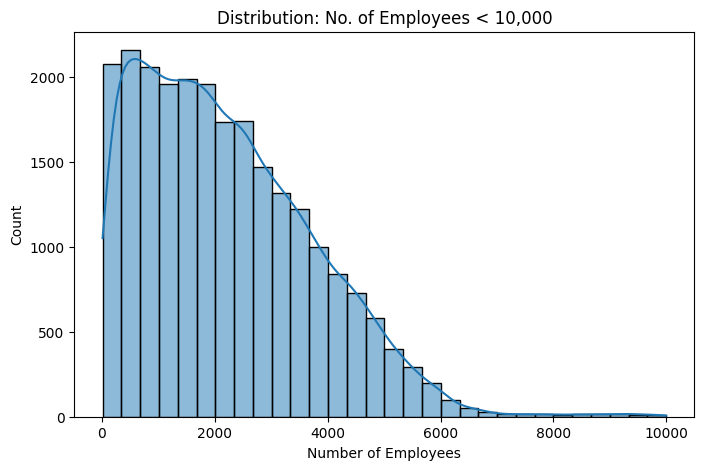

In [43]:
# Plotting histogram for no_of_employees column where count is below 10,000
plt.figure(figsize=(8, 5))
sns.histplot(data[data['no_of_employees'] < 10000]['no_of_employees'], bins=30, kde=True)
plt.xlabel('Number of Employees')
plt.ylabel('Count')
plt.title('Distribution: No. of Employees < 10,000')
plt.show()

**Observations:**

* Most companies have between 500 to 2,500 employees, and the number drops as employee count increases.

* The overall distribution is right-skewed, with very few companies having more than 6,000 employees.



---



**2. Prevailing Wage**

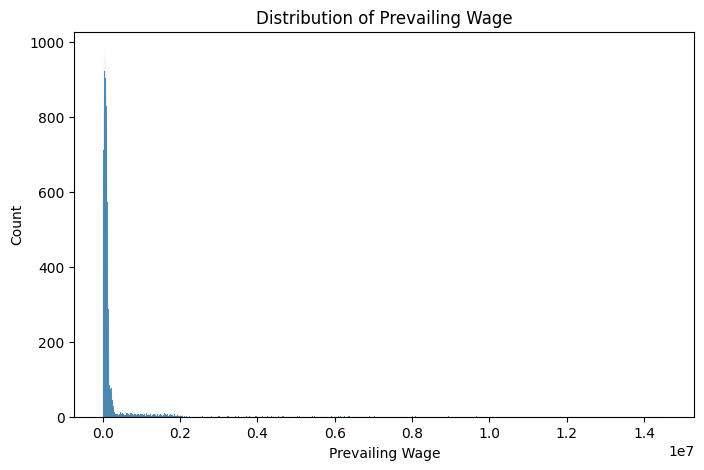

In [44]:
# Plotting histogram for prevailing_wage column
plt.figure(figsize=(8, 5))
sns.histplot(data=data, x='prevailing_wage', kde=False)
plt.xlabel('Prevailing Wage')
plt.ylabel('Count')
plt.title('Distribution of Prevailing Wage')
plt.show()

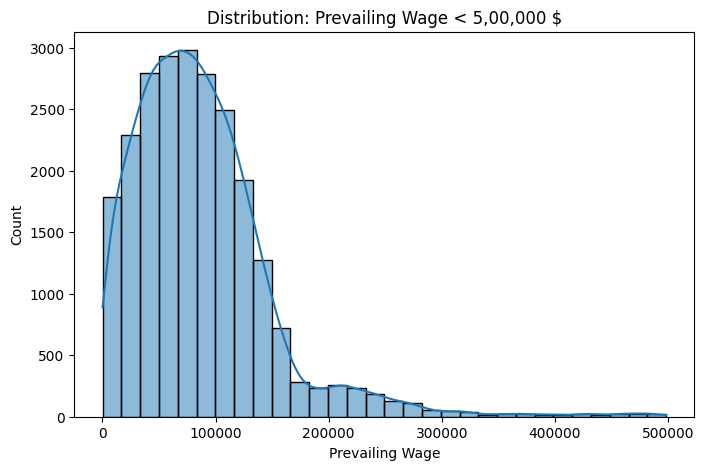

In [45]:
# Plotting histogram for prevailing_wage column where salary is below 5,00,000
plt.figure(figsize=(8, 5))
sns.histplot(data[data['prevailing_wage'] < 500000]['prevailing_wage'], bins=30, kde=True)
plt.xlabel('Prevailing Wage')
plt.ylabel('Count')
plt.title('Distribution: Prevailing Wage < 5,00,000 $')
plt.show()

**Observations:**

* The distribution is extremely right-skewed.

* The common wage range appears to be around 75K and 125K USD, with a steady decline in frequency as the wage increases.



---



**3. Age of company**

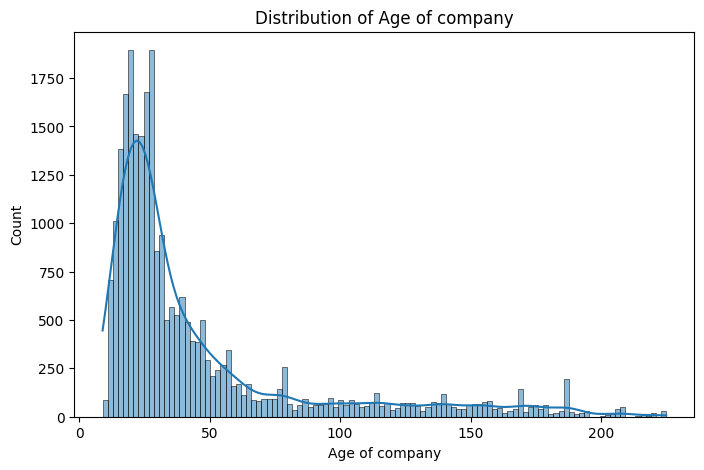

In [46]:
# Plotting histogram for age_company column
plt.figure(figsize=(8, 5))
sns.histplot(data=data, x='age_company', kde=True)
plt.xlabel('Age of company')
plt.ylabel('Count')
plt.title('Distribution of Age of company')
plt.show()

**Observations:**

* Most companies are less than 50 years old, with a noticeable peak between 20 and 40 years.

* The distribution is right-skewed, with very few companies older than 100 years.



---



#### **Categorical columns**

**1. Continent**

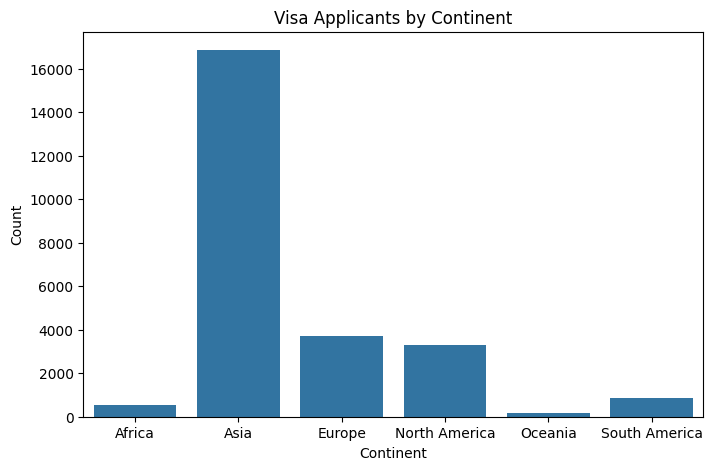

In [47]:
# Plotting countplot for continent column
plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='continent')
plt.title('Visa Applicants by Continent')
plt.xlabel('Continent')
plt.ylabel('Count')
plt.show()

**Observations:**

* Asia has the highest number of visa applicants by a large margin compared to other continents.

* Europe and North America follow, while Oceania, Africa, and South America have much lower counts.



---



**2. Education Of Employee**

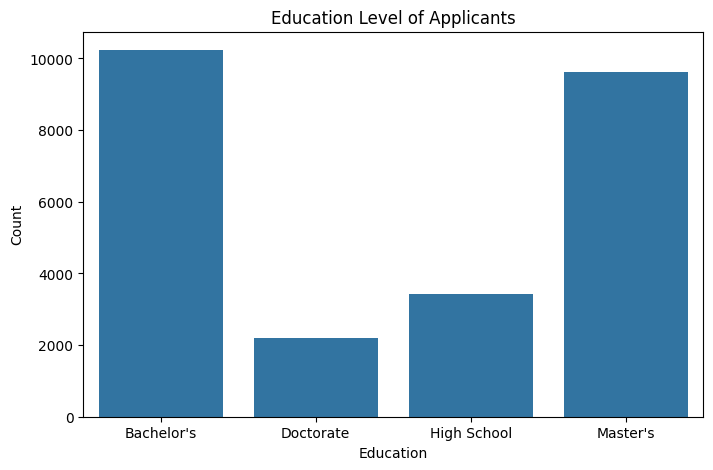

In [48]:
# Plotting countplot for education_of_employee column
plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='education_of_employee')
plt.title('Education Level of Applicants')
plt.xlabel('Education')
plt.ylabel('Count')
plt.show()

**Observations:**

* Most applicants hold a Bachelor’s or Master’s degree, making up the largest share.

* High School and Doctorate degree holders are fewer in comparison, with Doctorates being the least common among applicants.




---



**3. Region Of Employment**

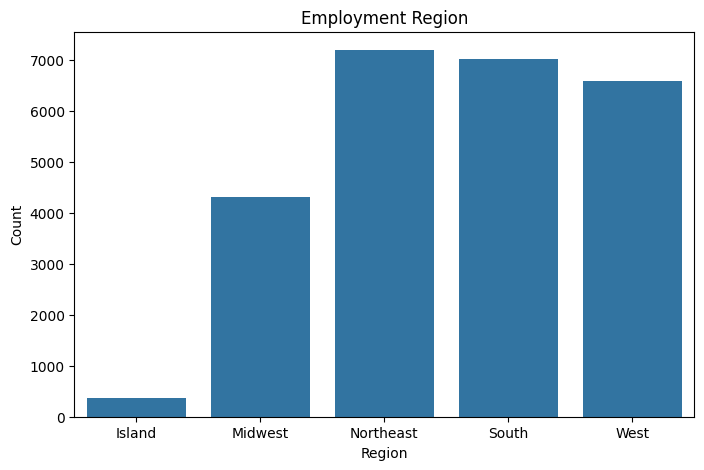

In [49]:
# Plotting countplot for region_of_employment column
plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='region_of_employment')
plt.title('Employment Region')
plt.xlabel('Region')
plt.ylabel('Count')
plt.show()

**Observations:**

* Most foreign workers are intended to be employed in the Northeast, South, and West regions of the United States.

* The Island region has the lowest employment demand, indicating fewer job positions for foreign workers in that area.



---



**4. Case Status**

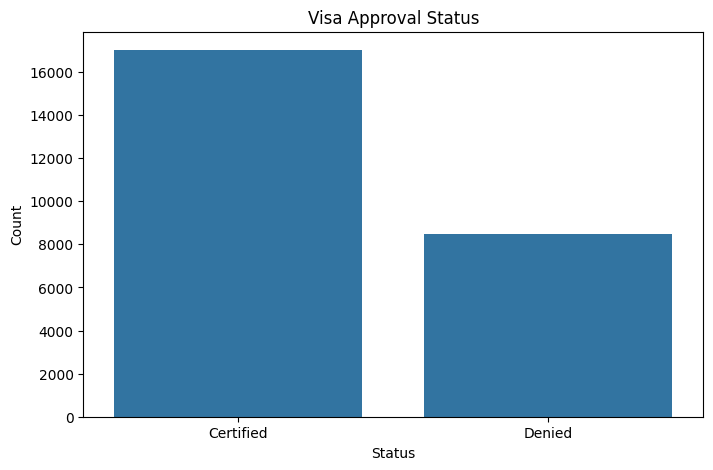

In [50]:
# Plotting countplot for case_status column
plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='case_status')
plt.title('Visa Approval Status')
plt.xlabel('Status')
plt.ylabel('Count')
plt.show()

**Observations:**

* The number of certified visa cases is much higher than the number of denied cases.

* This shows a class imbalance in the dataset, which may need to be addressed during model training using oversampling (SMOTE) or undersampling techniques.



---



#### **Binary Columns**

**1. Job Experience**

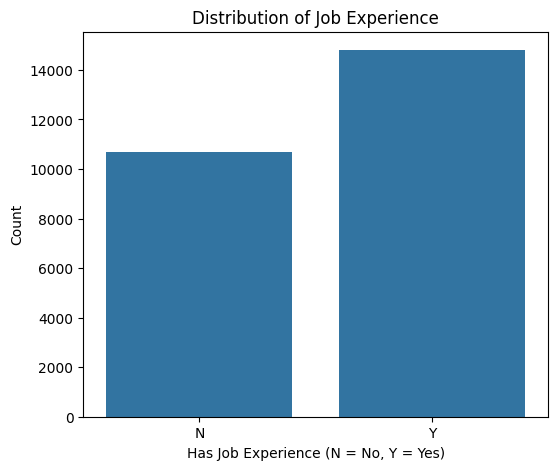

In [51]:
# Plotting countplot for has_job_experience column
plt.figure(figsize=(6, 5))
sns.countplot(data=data, x='has_job_experience')
plt.title('Distribution of Job Experience')
plt.xlabel('Has Job Experience (N = No, Y = Yes)')
plt.ylabel('Count')
plt.show()

**Observations:**

* A majority of applicants (Y) have prior job experience.

* However, a significant number (N) of applicants do not have job experience


---



**2. Job Training**

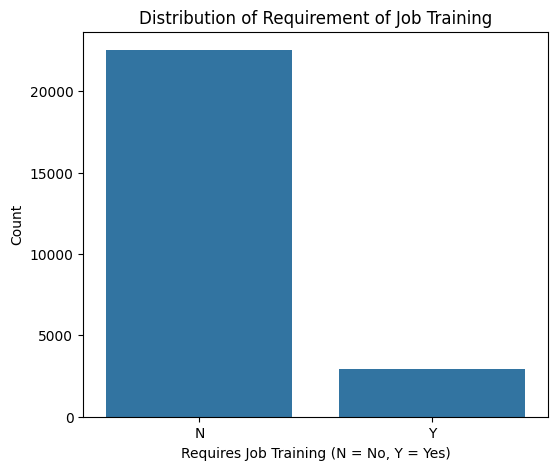

In [52]:
# Plotting countplot for requires_job_training column
plt.figure(figsize=(6, 5))
sns.countplot(data=data, x='requires_job_training')
plt.title('Distribution of Requirement of Job Training')
plt.xlabel('Requires Job Training (N = No, Y = Yes)')
plt.ylabel('Count')
plt.show()

**Observations:**

* Most applicants do not require job training (N), meaning they are likely ready to work immediately.

* Only a small portion (Y) of applicants need job training.


---



**3. Full Time Position**

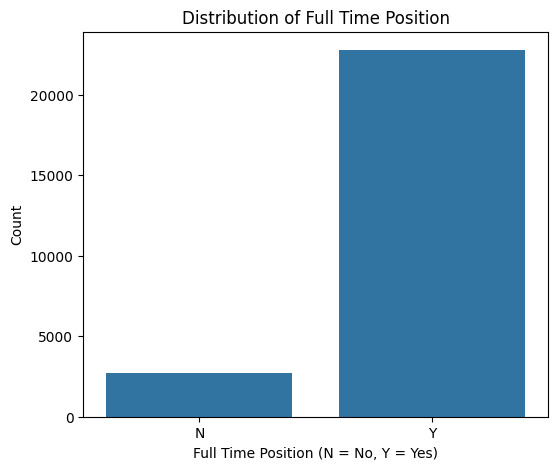

In [53]:
# Plotting countplot for full_time_position column
plt.figure(figsize=(6, 5))
sns.countplot(data=data, x='full_time_position')
plt.title('Distribution of Full Time Position')
plt.xlabel('Full Time Position (N = No, Y = Yes)')
plt.ylabel('Count')
plt.show()

**Observations:**

* The majority of visa positions are for full-time roles (Y).

* Only a small number of positions are part-time (N), suggesting that most job offers are for regular, long-term work.


---



## **Bivariate Analysis**

**1. Numerical Columns Correlation Heatmap**

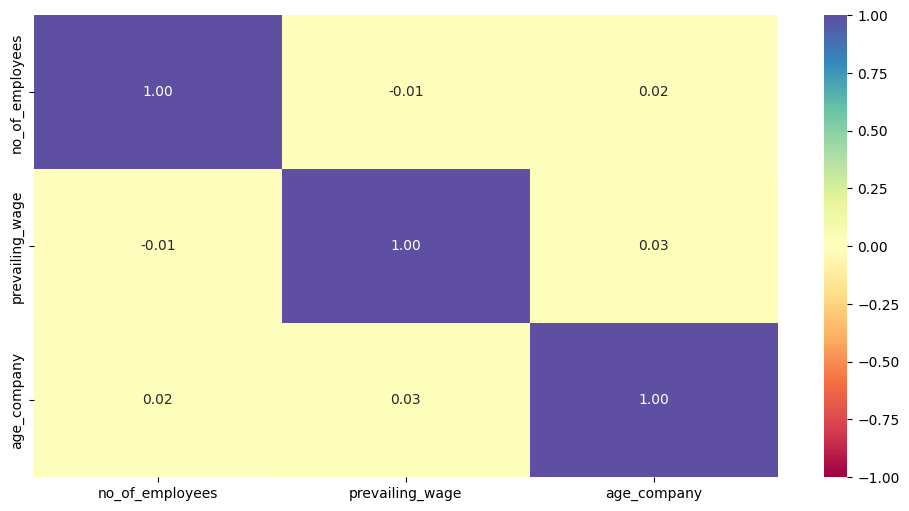

In [54]:
# Defining the size of the plot
plt.figure(figsize=(12, 6))

# Plotting the heatmap for correlation
sns.heatmap(data[num_columns].corr(),annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral");

**Observations:**

* There is no strong correlation between the numerical features : no_of_employees, prevailing_wage, and age_company have correlation values close to 0 with each other.



---



**2. Education of Employee vs Visa Case Status (Target Variable)**

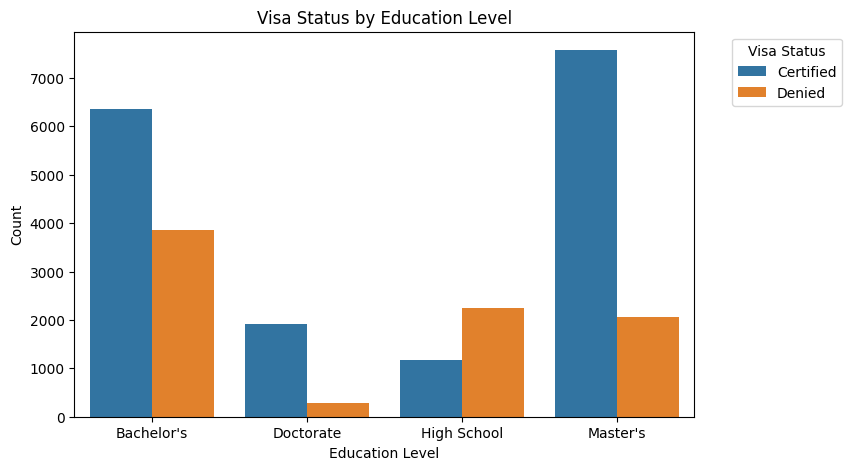

In [55]:
# Plotting countplot for Education Of Employee vs Case_Status
plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='education_of_employee', hue='case_status')
plt.title('Visa Status by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.legend(title='Visa Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

**Observations:**

* Master’s degree holders have the highest number of certified visas. Very few are denied.

* Bachelor’s degree is next in volume, but there are more denials compared to Master’s.

* High School education shows more denials than certifications.

* Doctorate holders also have high certification rates with very few denials.

---



**3. Continent vs Visa Case Status (Target Variable)**

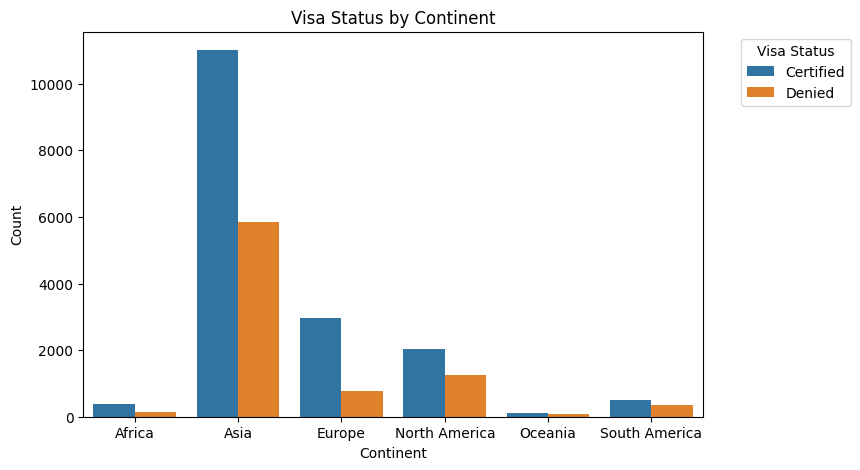

In [56]:
# Plotting countplot for Continent vs Case_Status
plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='continent', hue='case_status')
plt.title('Visa Status by Continent')
plt.xlabel('Continent')
plt.ylabel('Count')
plt.legend(title='Visa Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

**Observations:**

* Asia has the highest number of visa applications overall, with a significant portion certified. But it also has the highest number of denials.

* Europe and North America follow, with more certifications than denials.

* Africa, South America, and Oceania have much fewer applications. Most are certified.



---



**4. Region Of Employment vs Case Status (Target Variable)**

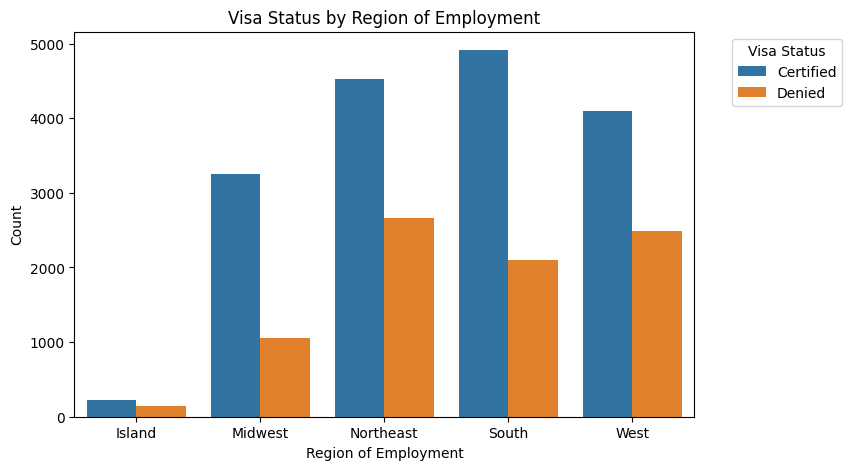

In [57]:
# Plotting countplot for region_of_employment vs Case_Status
plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='region_of_employment', hue='case_status')
plt.title('Visa Status by Region of Employment')
plt.xlabel('Region of Employment')
plt.ylabel('Count')
plt.legend(title='Visa Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


**Observations:**

* South and Northeast regions have the highest number of certified visa cases, along with reasonable numbers of denials.

* This is followed by the West and Midwest regions, which also show many certified cases but with relatively higher denial counts.

* The Island region has very few visa applications overall, with almost equal numbers of certified and denied cases.



---



**5. Job Experience vs Case Status (Target Variable)**

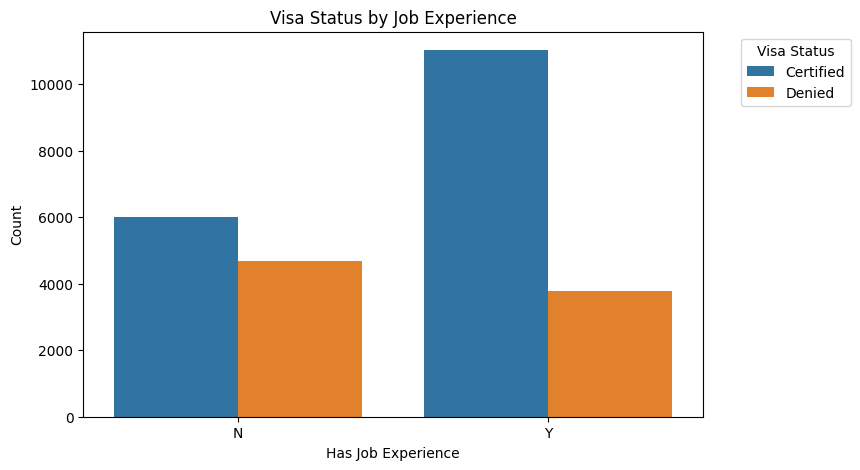

In [58]:
# Plotting countplot for has_job_experience vs Case_Status
plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='has_job_experience', hue='case_status')
plt.title('Visa Status by Job Experience')
plt.xlabel('Has Job Experience')
plt.ylabel('Count')
plt.legend(title='Visa Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

**Observations:**

* Applicants with job experience (Y) have a much higher number of certified visa cases and fewer denials.

* Applicants without job experience (N) still receive certifications, but the number of denials is also significantly higher in comparison.



---



**6. Full Time Position vs Case Status (Target Variable)**

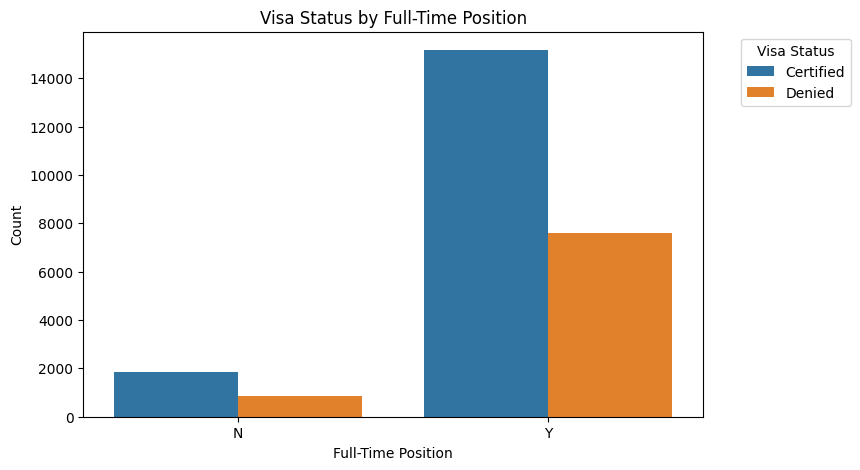

In [59]:
# Plotting countplot for full_time_position vs Case_Status
plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='full_time_position', hue='case_status')
plt.title('Visa Status by Full-Time Position')
plt.xlabel('Full-Time Position')
plt.ylabel('Count')
plt.legend(title='Visa Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

**Observations**:

* Full-time positions (Y) have a very high number of certified visa cases. Denials are also present but fewer compared to the certifications.

* Part time positions (N) show very few cases overall, with both certifications and denials being low.



---



**7. Prevailing Wage vs Case Status (Target Variable)**

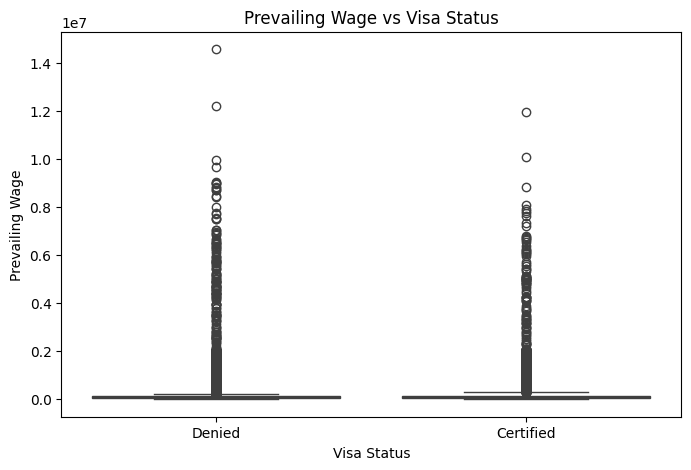

In [60]:
# Plotting countplot for prevailing_wage vs Case_Status
plt.figure(figsize=(8, 5))
sns.boxplot(data=data, x='case_status', y='prevailing_wage')
plt.title('Prevailing Wage vs Visa Status')
plt.xlabel('Visa Status')
plt.ylabel('Prevailing Wage')
plt.xticks([0, 1], ['Denied', 'Certified'])
plt.show()

**Observations:**

* Both Certified and Denied visa applications have a wide range of prevailing wages.

* There are many outliers on the higher end of the wage range for both classes.

* The overall spread is large, which suggests wages vary widely regardless of approval status.


---



**8. No Of Employees vs Case Status (Target Variable)**

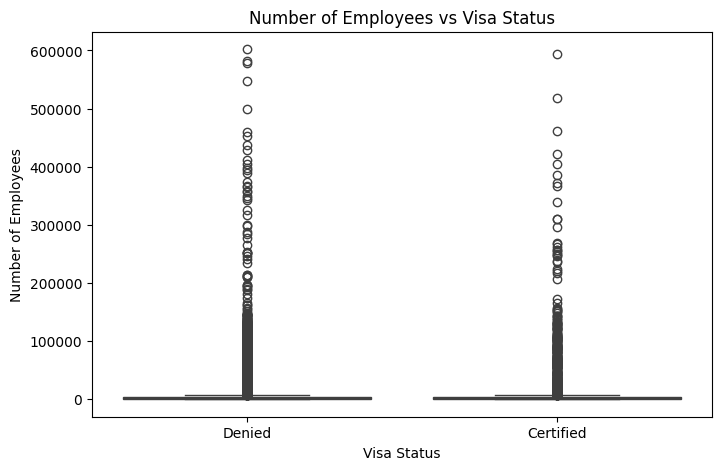

In [61]:
# Plotting countplot for no_of_employees vs Case_Status
plt.figure(figsize=(8, 5))
sns.boxplot(data=data, x='case_status', y='no_of_employees')
plt.title('Number of Employees vs Visa Status')
plt.xlabel('Visa Status')
plt.ylabel('Number of Employees')
plt.xticks([0, 1], ['Denied', 'Certified'])
plt.show()

**Observations:**

* Both Certified and Denied cases have companies with a huge range in number of employees.

* There are many extreme outliers, some companies have more than 500,000 employees.

* There is no clear visual separation between the two classes, meaning the number of employees doesn’t strongly affect the approval outcome.



---



**9. Age Of Company vs Case Status (Target Variable)**

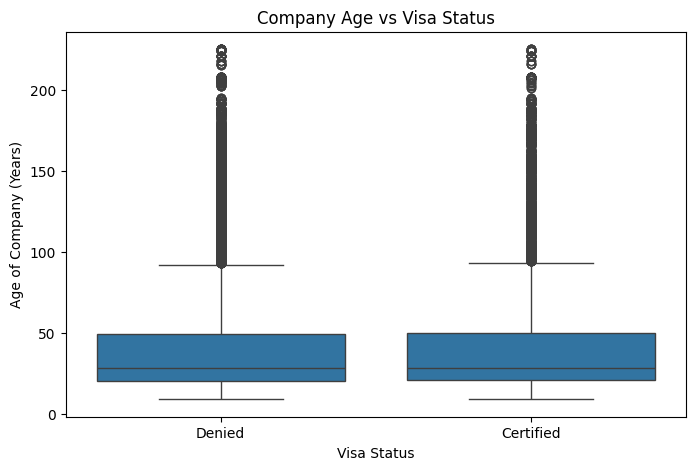

In [62]:
# Plotting countplot for age_company vs Case_Status
plt.figure(figsize=(8, 5))
sns.boxplot(data=data, x='case_status', y='age_company')
plt.title('Company Age vs Visa Status')
plt.xlabel('Visa Status')
plt.ylabel('Age of Company (Years)')
plt.xticks([0, 1], ['Denied', 'Certified'])
plt.show()

Observations:

* The median age of companies is almost the same for both Certified and Denied cases.

* Most companies are between 20 to 50 years old, with very few older than 100 years.

* There are many outliers, some companies are over 200 years old, but they are rare.

* The spread (IQR) and the distribution shape are also quite similar between the two classes.



---



**10. Pairplot showing relationships between all numeric variables:**

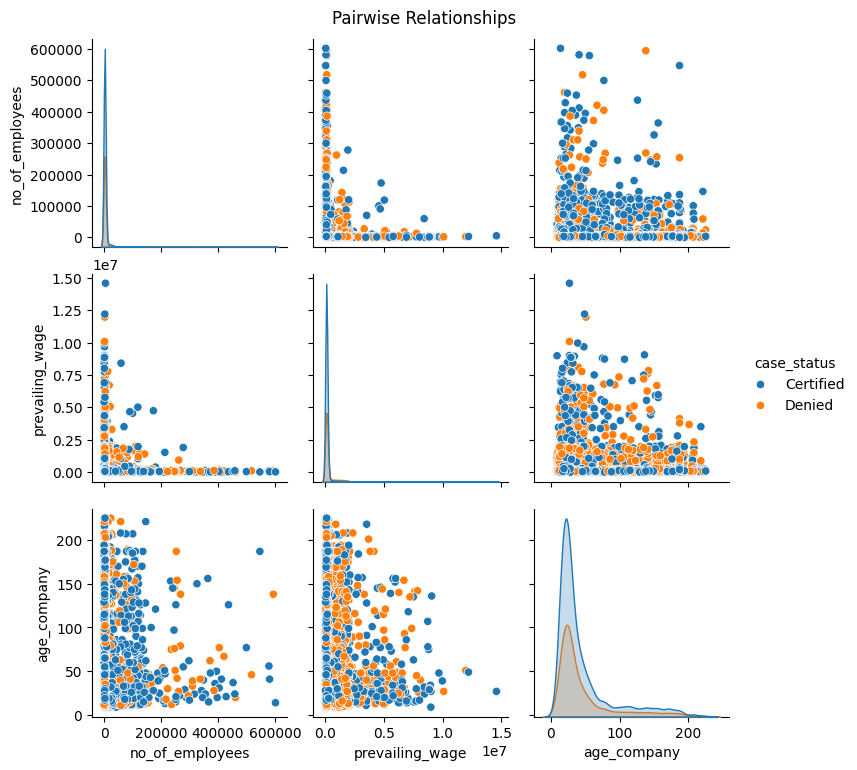

In [63]:
# Select only numerical columns and case_status for hue
num_cols = ['no_of_employees', 'prevailing_wage', 'age_company']
sns.pairplot(data[num_cols + ['case_status']], hue='case_status', diag_kind='kde')
plt.suptitle('Pairwise Relationships', y=1.02)
plt.show()

**Observations:**

* The numeric variables are not strongly correlated with each other.

* They also do not clearly separate Certified and Denied cases on their own.



---



### **Key Exploratory Data Analysis Observations:**

* The dataset is imbalanced, certified visa cases are much higher than denied ones. This will need to be handled using oversampling or undersampling techniques.

* Master’s and Doctorate degree holders have the highest approval rates, while High School applicants face more denials.

* Full-time roles and applicants with prior job experience are more likely to get visa approval.

* Numerical features like no_of_employees, prevailing_wage, and age_company are right-skewed with many outliers.

* Outliers are not removed, since tree-based models (Random Forest, Boosting, etc.) are robust and handle them well.

* No strong correlation exists between numerical features; individual numeric features do not clearly separate certified vs denied cases.



---



## **Data Pre-Processing**

### **Encoding categorical variables (Label Encoding and One-Hot Encoding)**

### **1. Label Encoding**

In [64]:
# Mapping dictionary for Label encoding
replaceStruct = {
                  "education_of_employee" : {"High School" : 1, "Bachelor's" : 2, "Master's" : 3,"Doctorate" : 4},
                  "has_job_experience" : {"N" : 0, "Y" : 1},
                  "requires_job_training" : {"N" : 0, "Y" : 1},
                  "full_time_position" : {"N" : 0, "Y" : 1},
                  "case_status" : {"Denied" : 0, "Certified" : 1}
 }

# Applying the replacement to the dataset
data =data.replace(replaceStruct)

data.head(3)

,continent,education_of_employee,has_job_experience,requires_job_training,no_of_employees,region_of_employment,prevailing_wage,full_time_position,case_status,age_company
0,Asia,1,0,0,14513,West,1231782.032,1,0,18
1,Asia,3,1,0,2412,Northeast,83425.650,1,1,23
2,Asia,2,0,1,44444,West,122996.860,1,0,17


### **2. One-Hot Encoding**

In [65]:
# Applying one-hot encoding to categorical columns
oneHotCols=["continent","region_of_employment"]
data = pd.get_dummies(data, columns =oneHotCols)

data.head(3)

,education_of_employee,has_job_experience,requires_job_training,no_of_employees,prevailing_wage,full_time_position,case_status,age_company,continent_Africa,continent_Asia,continent_Europe,continent_North America,continent_Oceania,continent_South America,region_of_employment_Island,region_of_employment_Midwest,region_of_employment_Northeast,region_of_employment_South,region_of_employment_West
0,1,0,0,14513,1231782.032,1,0,18,False,True,False,False,False,False,False,False,False,False,True
1,3,1,0,2412,83425.650,1,1,23,False,True,False,False,False,False,False,False,True,False,False
2,2,0,1,44444,122996.860,1,0,17,False,True,False,False,False,False,False,False,False,False,True


In [66]:
data.shape

(25480, 19)

**Obervations:**

* After encoding, the dataset now contains 19 columns.

* All features are now numerical, making the dataset ready for machine learning model training.



---



## **Split the data into train and test sets**

In [67]:
# Feature-target split
X = data.drop("case_status", axis =1)
y = data['case_status']

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify =y)

In [69]:
# Print shapes
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print("-" * 60)

# Print class distribution (in percentage)
def print_class_distribution(name, target):
    print(f"Class distribution in {name}:")
    print(target.value_counts(normalize=True).round(4) * 100)
    print("-" * 60)

# Check balance
print_class_distribution("Full Dataset (y)", y)
print_class_distribution("Training Set (y_train)", y_train)
print_class_distribution("Test Set (y_test)", y_test)

X_train shape: (17836, 18)
y_train shape: (17836,)
X_test shape: (7644, 18)
y_test shape: (7644,)
------------------------------------------------------------
Class distribution in Full Dataset (y):
case_status
1    66.79
0    33.21
Name: proportion, dtype: float64
------------------------------------------------------------
Class distribution in Training Set (y_train):
case_status
1    66.79
0    33.21
Name: proportion, dtype: float64
------------------------------------------------------------
Class distribution in Test Set (y_test):
case_status
1    66.78
0    33.22
Name: proportion, dtype: float64
------------------------------------------------------------


**Observations:**

* The dataset has been split into:
  * Training set: 17,836 rows
  * Test set: 7,644 rows

* The class distribution is consistent across full data, training, and test sets:
  * ~66.8% of the cases are Certified (1)
  * ~33.2% are Denied (0)

## **Model evaluation criterion**

**What does EasyVisa want?**

EasyVisa wants to assist visa officers by accurately predicting which applications should be certified or denied. The goal is to make fair and accurate visa decisions and avoid two types of mistakes:
  * Approving a candidate who should be denied (false positive)
  * Denying a candidate who actually qualifies (false negative)

**Which loss is greater?**

Both can have serious consequences:
  * Approving an unqualified applicant may lead to workforce issues.
  * Denying a qualified applicant results in a missed opportunity for skilled talent.

Because both types of errors matter in this problem, we cannot rely on accuracy alone.

**So, we should use the F1 Score as our evaluation metric.**
* It balances Precision (avoiding false approvals) and Recall (avoiding false denials).
* A high F1 Score indicates the model performs well on both fronts.

## **Model Building - Original Data**

In [70]:
# Defining function to compute different metrics to check performance of classification model built using sklearn

def model_performance_classification (model, predictors, target):

  # Predicting using independent variable
  pred = model.predict(predictors)

  # Computer Accuracy, Recall, Precision & F1 Score
  acc = accuracy_score(target, pred)
  recall = recall_score(target, pred)
  precision = precision_score(target, pred)
  f1 = f1_score(target, pred)

  # Creating dataframe of metrics
  df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )
  return df_perf

In [71]:
# Creating function for confusion matrix

def plot_confusion_matrix (model, predictors, target):

  # Predict target values using the model and pedictors
  y_pred = model.predict(predictors)

  # Compute confusion matrix comparing the true target values with predicted values
  cm = confusion_matrix(target, y_pred)

  # Creating labels for each cell in the confusion matrix with both count and percentage
  labels = np.asarray(
      [
          ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
          for item in cm.flatten()
      ]
  ).reshape(2,2)

  #Figure size for plot
  plt.figure(figsize = (6,4))

  # Plot confusion matrix as heatmap
  sns.heatmap(cm, annot = labels, fmt = "")
  plt.ylabel("True Label")
  plt.xlabel("Predicted Label")

## **1. Decision Tree (dt_model_1)**

In [72]:
# Initialize the Decision Tree model
dt_model_1 = DecisionTreeClassifier(random_state=42)

# Fit the model on the training data
dt_model_1.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [73]:
# Display the feature importance scores for each input feature
print(pd.DataFrame(dt_model_1.feature_importances_, columns = ["imp"], index = X_train.columns))

                                     imp
education_of_employee           0.111743
has_job_experience              0.047980
requires_job_training           0.016895
no_of_employees                 0.250162
prevailing_wage                 0.274493
full_time_position              0.012507
age_company                     0.169312
continent_Africa                0.004190
continent_Asia                  0.010269
continent_Europe                0.020527
continent_North America         0.009233
continent_Oceania               0.003408
continent_South America         0.007987
region_of_employment_Island     0.004061
region_of_employment_Midwest    0.019052
region_of_employment_Northeast  0.012694
region_of_employment_South      0.013750
region_of_employment_West       0.011737


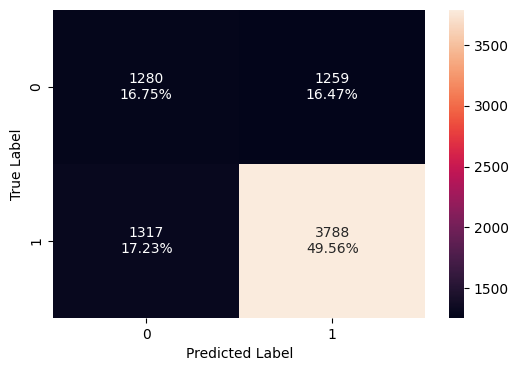

In [74]:
# Test set confusion matrix
plot_confusion_matrix(dt_model_1, X_test, y_test)

In [75]:
# Training set performance
dt_train_perf_1 = model_performance_classification(dt_model_1, X_train, y_train)
dt_train_perf_1

,Accuracy,Recall,Precision,F1
0,1.0,1.0,1.0,1.0


In [76]:
# Test set performance
dt_test_perf_1 = model_performance_classification(dt_model_1, X_test, y_test)
dt_test_perf_1

,Accuracy,Recall,Precision,F1
0,0.663004,0.742018,0.750545,0.746257


**Observations:**

* Feature Importance: The most important features for prediction are:
  * prevailing_wage (27%)
  * no_of_employees (25%)
  * age_company (17%)
  * education_of_employee (11%)

* Categorical features like continent and region_of_employment contribute very little individually

* Training performance is perfect (1.0), indicating that the decision tree has overfit the training data.

* Test performance is much lower, especially in accuracy (66%), confirming overfitting.

* However, the model maintains a reasonably good F1 score (0.746), showing balanced precision and recall on unseen data.



---



## **2. Bagging Classifier (bag_model_1)**

In [77]:
bag_model_1 = BaggingClassifier(random_state=42)
bag_model_1.fit(X_train,y_train)

BaggingClassifier(random_state=42)

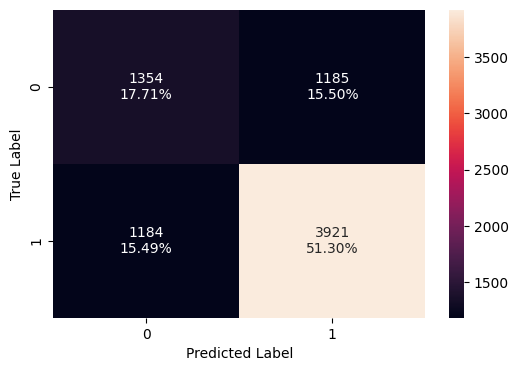

In [78]:
# Test set confusion matrix
plot_confusion_matrix(bag_model_1, X_test, y_test)

In [79]:
# Training set performance
bag_train_perf_1 = model_performance_classification(bag_model_1, X_train, y_train)
bag_train_perf_1

,Accuracy,Recall,Precision,F1
0,0.98475,0.98489,0.99222,0.988542


In [80]:
# Test set performance
bag_test_perf_1 = model_performance_classification(bag_model_1, X_test, y_test)
bag_test_perf_1

,Accuracy,Recall,Precision,F1
0,0.690084,0.768071,0.76792,0.767995


**Observations:**

* The training set performance is very high (F1 = 0.989), suggesting overfitting.

* On the test set, performance drops, F1 Score: 0.768, Recall and Precision are well-balanced, both at ~76.8%.

* The Bagging model performs slightly better than decision tree in terms of recall and generalization.

---



## **3. Random Forest Classifier (rf_model_1)**

In [81]:
rf_model_1 = RandomForestClassifier(random_state=42)
rf_model_1.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

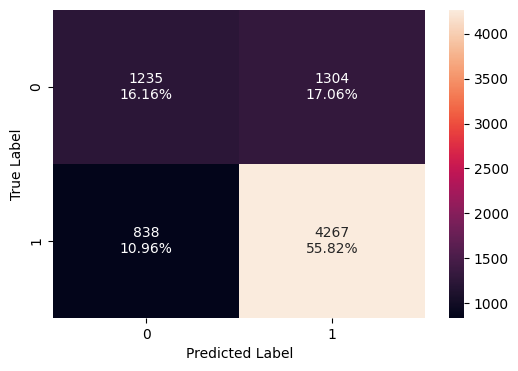

In [82]:
# Test set confusion matrix
plot_confusion_matrix(rf_model_1, X_test, y_test)

In [83]:
# Training set performance
rf_train_perf_1 = model_performance_classification(rf_model_1, X_train, y_train)
rf_train_perf_1

,Accuracy,Recall,Precision,F1
0,1.0,1.0,1.0,1.0


In [84]:
# Test set performance
rf_test_perf_1 = model_performance_classification(rf_model_1, X_test, y_test)
rf_test_perf_1

,Accuracy,Recall,Precision,F1
0,0.71978,0.835847,0.765931,0.799363


**Observations:**

* Training performance is perfect (1.0) across all metrics, which clearly indicates overfitting.

* On the test set, the model performs reasonably well with an F1 score of 0.799, strong recall (83.6%), and good precision (76.6%).

* The Random Forest model overfits heavily, and although it does better than a decision tree and bagging model, the test set results are just moderately good.



---



## **4. AdaBoost Classifier (abc_model_1)**

In [85]:
abc_model_1 = AdaBoostClassifier(random_state=42)
abc_model_1.fit(X_train,y_train)

AdaBoostClassifier(random_state=42)

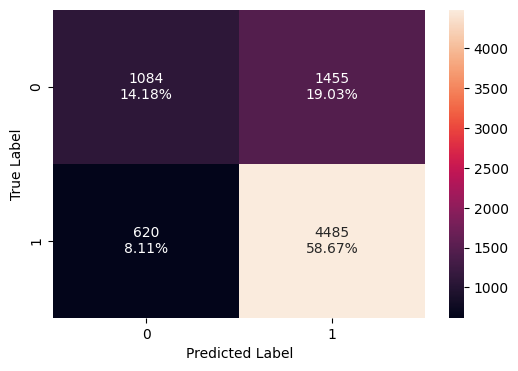

In [86]:
# Test set confusion matrix
plot_confusion_matrix(abc_model_1, X_test, y_test)

In [87]:
# Training set performance
abc_train_perf_1 = model_performance_classification(abc_model_1, X_train, y_train)
abc_train_perf_1

,Accuracy,Recall,Precision,F1
0,0.735479,0.881558,0.760519,0.816577


In [88]:
# Test set performance
abc_test_perf_1 = model_performance_classification(abc_model_1, X_test, y_test)
abc_test_perf_1

,Accuracy,Recall,Precision,F1
0,0.728545,0.87855,0.755051,0.812132


**Observations:**

* Training and test metrics are close, which shows low overfitting indicating a decent model.

* AdaBoost gives the best overall F1 score so far with balanced generalization and high recall.



---



## **5. Gradient Boosting Classifier (gbc_model_1)**

In [89]:
gbc_model_1 = GradientBoostingClassifier(random_state=42)
gbc_model_1.fit(X_train,y_train)

GradientBoostingClassifier(random_state=42)

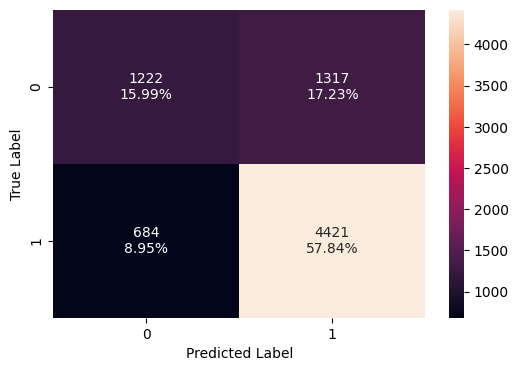

In [90]:
# Test set confusion matrix
plot_confusion_matrix(gbc_model_1, X_test, y_test)

In [91]:
# Training set performance
gbc_train_perf_1 = model_performance_classification(gbc_model_1, X_train, y_train)
gbc_train_perf_1

,Accuracy,Recall,Precision,F1
0,0.753308,0.872576,0.782933,0.825328


In [92]:
# Test set performance
gbc_test_perf_1 = model_performance_classification(gbc_model_1, X_test, y_test)
gbc_test_perf_1

,Accuracy,Recall,Precision,F1
0,0.738226,0.866014,0.770478,0.815457


**Observations:**

* F1 Score on test set (0.815) is among the best so far, showing a strong balance between precision and recall.

* Recall is very high (86.6%), meaning the model captures most actual certified cases.

* Precision (77.0%) is slightly better than AdaBoost (75.6%), fewer false approvals.

* Training and test performance are close, suggesting low overfitting and good generalization.



---



## **Comparing all models (Original Data)**

In [93]:
# List of model names and their corresponding train/test DataFrames for orginal data
models = [
    ("Decision Tree", dt_train_perf_1, dt_test_perf_1),
    ("Bagging Classifier", bag_train_perf_1, bag_test_perf_1),
    ("Random Forest Classifier", rf_train_perf_1, rf_test_perf_1),
    ("AdaBoost Classifier", abc_train_perf_1, abc_test_perf_1),
    ("Gradient Boosting Classifier", gbc_train_perf_1, gbc_test_perf_1)
]

# Create a list to store final rows
combined_rows = []

# Loop through each model and extract scores
for model_name, train_df, test_df in models:
    row = {
        'Model': model_name,
        'Train_Accuracy': train_df['Accuracy'][0],
        'Test_Accuracy': test_df['Accuracy'][0],
        'Train_Recall': train_df['Recall'][0],
        'Test_Recall': test_df['Recall'][0],
        'Train_Precision': train_df['Precision'][0],
        'Test_Precision': test_df['Precision'][0],
        'Train_F1': train_df['F1'][0],
        'Test_F1': test_df['F1'][0],
    }
    combined_rows.append(row)

# Create final comparison DataFrame
comparison_df = pd.DataFrame(combined_rows)
comparison_df

,Model,Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_Precision,Test_Precision,Train_F1,Test_F1
0,Decision Tree,1.000000,0.663004,1.000000,0.742018,1.000000,0.750545,1.000000,0.746257
1,Bagging Classifier,0.984750,0.690084,0.984890,0.768071,0.992220,0.767920,0.988542,0.767995
2,Random Forest Classifier,1.000000,0.719780,1.000000,0.835847,1.000000,0.765931,1.000000,0.799363
3,AdaBoost Classifier,0.735479,0.728545,0.881558,0.878550,0.760519,0.755051,0.816577,0.812132
4,Gradient Boosting Classifier,0.753308,0.738226,0.872576,0.866014,0.782933,0.770478,0.825328,0.815457


### **Key Observations from Orginal Data Model Building:**

* **Gradient Boosting Classifier** achieved the highest F1 score on the test set (0.815), with excellent recall and minimal overfitting. It generalizes very well and is the most balanced model overall.

* **AdaBoost Classifier** closely followed with a strong F1 score (0.812) and the highest recall (87.9%). It maintained consistent performance across both train and test sets, indicating low overfitting.

* **Random Forest Classifier** performed well on the test set (F1 = 0.799) with high recall, but perfect training scores (F1 = 1.0) indicate clear overfitting. It would benefit from hyperparameter tuning.

* **Bagging Classifier** achieved a test F1 score of 0.768 with balanced precision and recall, but still showed signs of overfitting due to high training performance.

* **Decision Tree** had the lowest test accuracy and F1 score (0.746). It overfits the training data completely and generalizes poorly to unseen data.


---



## **Model Building - Oversampled Data**

## **Oversampling train data using SMOTE**

In [94]:
# Check the original class distribution in the training set (before oversampling)
y_train.value_counts(normalize = True)

,proportion
case_status,
1,0.667919
0,0.332081


* The training set is moderately imbalanced, with approximately 66.8% Certified cases (class 1) and 33.2% Denied cases (class 0).

* To address this, oversampling techniques like SMOTE are necessary to balance the class distribution and help the model learn patterns for both classes equally.

In [95]:
# Fit SMOTE on train data(Synthetic Minority Oversampling Technique)
sm = SMOTE(random_state=42)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

# Print new class distribution after oversampling
print("After SMOTE:")
print(y_train_over.value_counts(normalize=True).round(3))

After SMOTE:
case_status
1    0.5
0    0.5
Name: proportion, dtype: float64


**Observations:**

* After applying SMOTE, the training set is now perfectly balanced, with 50% Certified cases (class 1) and 50% Denied cases (class 0).

* This balanced distribution ensures that the model gives equal attention to both classes, helping it learn the patterns of the minority class more effectively.



---



## **1. Decision Tree (dt_model_2)**

In [96]:
# Initialize the Decision Tree model
dt_model_2 = DecisionTreeClassifier(random_state=42)

# Fit the model on the training data
dt_model_2.fit(X_train_over, y_train_over)

DecisionTreeClassifier(random_state=42)

In [97]:
# Display the feature importance scores for each input feature
print(pd.DataFrame(dt_model_2.feature_importances_, columns = ["imp"], index = X_train_over.columns))

                                     imp
education_of_employee           0.273460
has_job_experience              0.071164
requires_job_training           0.016154
no_of_employees                 0.176166
prevailing_wage                 0.191457
full_time_position              0.022464
age_company                     0.125891
continent_Africa                0.004354
continent_Asia                  0.019779
continent_Europe                0.015653
continent_North America         0.007257
continent_Oceania               0.001799
continent_South America         0.004598
region_of_employment_Island     0.002843
region_of_employment_Midwest    0.012859
region_of_employment_Northeast  0.020840
region_of_employment_South      0.014655
region_of_employment_West       0.018608


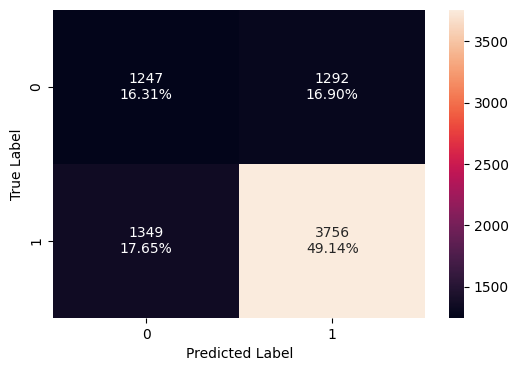

In [98]:
# Test set confusion matrix
plot_confusion_matrix(dt_model_2, X_test, y_test)

In [99]:
# Training set performance
dt_train_perf_2 = model_performance_classification(dt_model_2, X_train_over, y_train_over)
dt_train_perf_2

,Accuracy,Recall,Precision,F1
0,0.999958,1.0,0.999916,0.999958


In [100]:
# Test set performance
dt_test_perf_2 = model_performance_classification(dt_model_2, X_test, y_test)
dt_test_perf_2

,Accuracy,Recall,Precision,F1
0,0.6545,0.735749,0.744057,0.73988


**Observations:**

* The feature importance plot shows that the model relies most heavily on: education_of_employee, prevailing_wage, age_company, and no_of_employees.

* The model shows perfect performance on the training set, with F1, recall, and precision all close to 1.0. This indicates that the tree has likely overfit the oversampled training data.

* On the test set, performance drops significantly, these scores are moderate, suggesting the model does not generalize well to real-world data.

---



## **2. Bagging Classifier (bag_model_2)**

In [101]:
bag_model_2 = BaggingClassifier(random_state=42)
bag_model_2.fit(X_train_over,y_train_over)

BaggingClassifier(random_state=42)

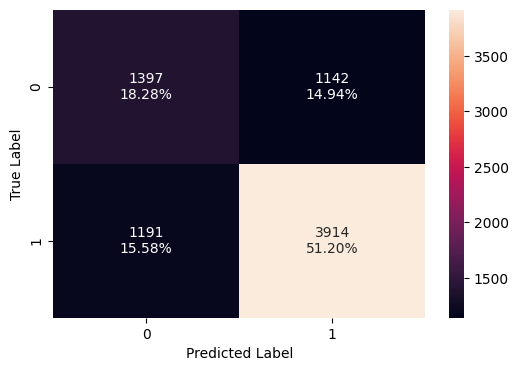

In [102]:
# Test set confusion matrix
plot_confusion_matrix(bag_model_2, X_test, y_test)

In [103]:
# Training set performance
bag_train_perf_2 = model_performance_classification(bag_model_2, X_train_over, y_train_over)
bag_train_perf_2

,Accuracy,Recall,Precision,F1
0,0.986989,0.981617,0.992278,0.986919


In [104]:
# Test set performance
bag_test_perf_2 = model_performance_classification(bag_model_2, X_test, y_test)
bag_test_perf_2

,Accuracy,Recall,Precision,F1
0,0.694793,0.766699,0.77413,0.770397


**Observations:**

* The training set performance is extremely high, with nearly perfect scores across all metrics. This is a clear sign of overfitting.

* On the test set, performance drops significantly. The F1 score is 0.77, with balanced precision and recall around 76%.

---



## **3. Random Forest Classifier (rf_model_2)**

In [105]:
rf_model_2 = RandomForestClassifier(random_state=42)
rf_model_2.fit(X_train_over, y_train_over)

RandomForestClassifier(random_state=42)

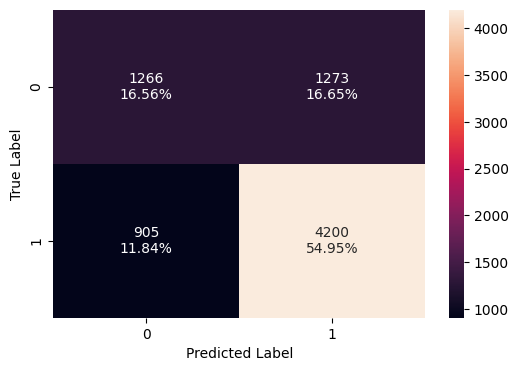

In [106]:
# Test set confusion matrix
plot_confusion_matrix(rf_model_2, X_test, y_test)

In [107]:
# Training set performance
rf_train_perf_2 = model_performance_classification(rf_model_2, X_train_over, y_train_over)
rf_train_perf_2

,Accuracy,Recall,Precision,F1
0,1.0,1.0,1.0,1.0


In [108]:
# Test set performance
rf_test_perf_2 = model_performance_classification(rf_model_2, X_test, y_test)
rf_test_perf_2

,Accuracy,Recall,Precision,F1
0,0.715071,0.822723,0.767404,0.794101


**Observations:**

* The training performance is perfect (F1 = 1.0), which is a strong indication of overfitting, the model memorized the oversampled data completely.

* On the test set, the model performs reasonably well, with an F1 score of 0.794 and recall of 82.3%, showing that it is still able to detect most certified cases correctly.

* Compared to other models, this Random Forest offers one of the best test F1 scores, but the overfitting is significant.



---



## **4. AdaBoost Classifier (abc_model_2)**

I'm converting the categorical columns in X_train into numeric codes because SMOTE only works with numerical data. If I pass categorical features directly, SMOTE may generate intermediate values between category values, which can result in invalid values or NaNs. Although the original training data had no missing values, NaNs were introduced during oversampling due to this issue. To resolve this, I’m converting all categorical columns using .cat.codes and then applying SMOTE on the cleaned dataset (X_fixed_abc). This allows SMOTE to generate a balanced training set without errors and ensures compatibility with AdaBoost, which does not support missing values.

In [109]:
# Convert categorical columns to numeric codes (required for SMOTE)
X_fixed = X_train.copy()
for col in X_fixed.select_dtypes(include='category').columns:
    X_fixed[col] = X_fixed[col].cat.codes

sm = SMOTE(random_state=42)
X_train_over_abc, y_train_over_abc = sm.fit_resample(X_fixed, y_train)

In [110]:
abc_model_2 = AdaBoostClassifier(random_state=42)
abc_model_2.fit(X_train_over_abc,y_train_over_abc)

AdaBoostClassifier(random_state=42)

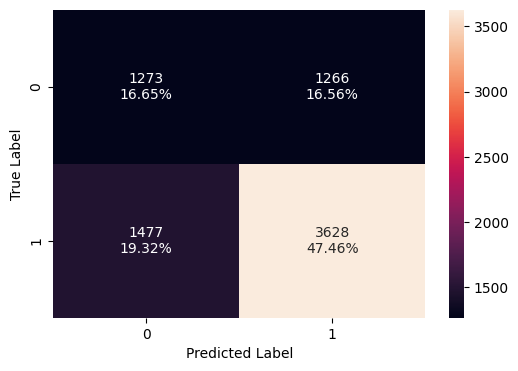

In [111]:
# Test set confusion matrix
plot_confusion_matrix(abc_model_2, X_test, y_test)

In [112]:
# Training set performance
abc_train_perf_2 = model_performance_classification(abc_model_2, X_train_over_abc, y_train_over_abc)
abc_train_perf_2

,Accuracy,Recall,Precision,F1
0,0.75489,0.788047,0.739038,0.762756


In [113]:
# Test set performance
abc_test_perf_2 = model_performance_classification(abc_model_2, X_test, y_test)
abc_test_perf_2

,Accuracy,Recall,Precision,F1
0,0.641156,0.710676,0.741316,0.725673


**Observations:**

* The training performance is moderate, with F1 = 0.763 and balanced recall/precision, which shows the model did not overfit on oversampled data.

* On the test set, performance drops, with F1 score = 0.726, accuracy = 0.641, and recall around 71%. This shows reasonable generalization but not strong model

* The AdaBoost classifier trained on oversampled data performs decently, with no major overfitting, but its overall predictive power is moderate.



---




## **5. Gradient Boosting Classifier (gbc_model_2)**

In [114]:
# Convert categorical columns to numeric codes (required for SMOTE)
X_fixed_gbc = X_train.copy()
for col in X_fixed_gbc.select_dtypes(include='category').columns:
    X_fixed_gbc[col] = X_fixed_gbc[col].cat.codes

sm = SMOTE(random_state=42)
X_train_over_gbc, y_train_over_gbc = sm.fit_resample(X_fixed_gbc, y_train)

In [115]:
gbc_model_2 = GradientBoostingClassifier(random_state=42)
gbc_model_2.fit(X_train_over_gbc,y_train_over_gbc)

GradientBoostingClassifier(random_state=42)

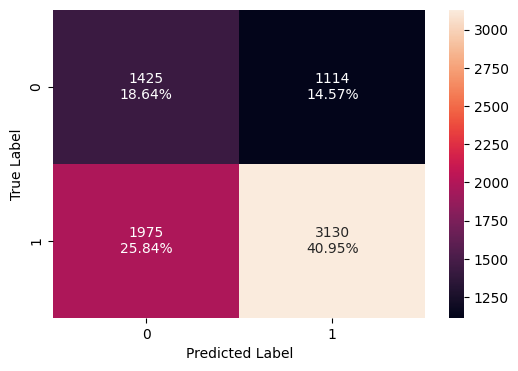

In [116]:
# Test set confusion matrix
plot_confusion_matrix(gbc_model_2, X_test, y_test)

In [117]:
# Training set performance
gbc_train_perf_2 = model_performance_classification(gbc_model_2, X_train_over_gbc, y_train_over_gbc)
gbc_train_perf_2

,Accuracy,Recall,Precision,F1
0,0.796021,0.826912,0.778797,0.802133


In [118]:
# Test set performance
gbc_test_perf_2 = model_performance_classification(gbc_model_2, X_test, y_test)
gbc_test_perf_2

,Accuracy,Recall,Precision,F1
0,0.595892,0.613124,0.737512,0.66959


**Observations:**

* The model performs well on the training set with a strong F1 score of 0.80, and recall around 83%, showing that it learned patterns from the oversampled data effectively.

* However, performance drops significantly on the test set. The F1 score drops to 0.66, and recall drops to 61.3%.

* Gradient Boosting on oversampled data shows signs of underfitting the minority class in the test set. While it learns well on the balanced training data, it doesn't generalize as well on unseen data.


---



## Comparing all models (Oversampled Data)

In [119]:
# List of model names and their corresponding train/test DataFrames
models_over = [
    ("Decision Tree", dt_train_perf_2, dt_test_perf_2),
    ("Bagging Classifier", bag_train_perf_2, bag_test_perf_2),
    ("Random Forest Classifier", rf_train_perf_2, rf_test_perf_2),
    ("AdaBoost Classifier", abc_train_perf_2, abc_test_perf_2),
    ("Gradient Boosting Classifier", gbc_train_perf_2, gbc_test_perf_2)
]

# Create a list to store final rows
combined_rows_over = []

# Loop through each model and extract scores
for model_name, train_df, test_df in models_over:
    row_over = {
        'Model': model_name,
        'Train_Accuracy': train_df['Accuracy'][0],
        'Test_Accuracy': test_df['Accuracy'][0],
        'Train_Recall': train_df['Recall'][0],
        'Test_Recall': test_df['Recall'][0],
        'Train_Precision': train_df['Precision'][0],
        'Test_Precision': test_df['Precision'][0],
        'Train_F1': train_df['F1'][0],
        'Test_F1': test_df['F1'][0],
    }
    combined_rows_over.append(row_over)

# Create final comparison DataFrame
comparison_df_over = pd.DataFrame(combined_rows_over)
comparison_df_over

,Model,Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_Precision,Test_Precision,Train_F1,Test_F1
0,Decision Tree,0.999958,0.654500,1.000000,0.735749,0.999916,0.744057,0.999958,0.739880
1,Bagging Classifier,0.986989,0.694793,0.981617,0.766699,0.992278,0.774130,0.986919,0.770397
2,Random Forest Classifier,1.000000,0.715071,1.000000,0.822723,1.000000,0.767404,1.000000,0.794101
3,AdaBoost Classifier,0.754890,0.641156,0.788047,0.710676,0.739038,0.741316,0.762756,0.725673
4,Gradient Boosting Classifier,0.796021,0.595892,0.826912,0.613124,0.778797,0.737512,0.802133,0.669590


### **Key Observations from Oversampled Data Model Building:**

* **Random Forest Classifier** delivered the strongest test performance with an F1 score of 0.794 and high recall (82.3%). However it overfits on training data (F1 = 1.0), it still generalizes better than other models on the test set.

* **Bagging Classifier** achieved a solid F1 score of 0.770 with well-balanced recall and precision around 77%. It shows moderate overfitting but performs reliably on unseen data.

* **AdaBoost Classifier** maintained balanced train and test performance (F1 = 0.763 vs. 0.726). It didn’t overfit but also didn’t perform as strongly, making it a decent model.

* **Decision Tree** showed nearly perfect training scores (F1 = 0.999), but test F1 dropped to 0.740, confirming overfitting on oversampled data.

* **Gradient Boosting Classifier** struggled the most, with the lowest test F1 score (0.670) and recall (61.3%). While it learned well on training data, it failed to generalize effectively on unseen data

---



## **Undersampling train data using Random Undersampler**

In [120]:
# fit random under sampler on the train data
rus = RandomUnderSampler(random_state=42, sampling_strategy = 1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

In [121]:
print("Before Under Sampling, count of label '1': {}".format(sum(y_train == 1)))
print("Before Under Sampling, count of label '0': {} \n".format(sum(y_train == 0)))

print("After Under Sampling, count of label '1': {}".format(sum(y_train_un == 1)))
print("After Under Sampling, count of label '0': {} \n".format(sum(y_train_un == 0)))

print("After Under Sampling, the shape of X_train_un: {}".format(X_train_un.shape))
print("After Under Sampling, the shape of y_train_un: {} \n".format(y_train_un.shape))

Before Under Sampling, count of label '1': 11913
Before Under Sampling, count of label '0': 5923 

After Under Sampling, count of label '1': 5923
After Under Sampling, count of label '0': 5923 

After Under Sampling, the shape of X_train_un: (11846, 18)
After Under Sampling, the shape of y_train_un: (11846,) 



## **1. Decision Tree (dt_model_3)**

In [122]:
# Initialize the Decision Tree model
dt_model_3 = DecisionTreeClassifier(random_state=42)

# Fit the model on the training data
dt_model_3.fit(X_train_un, y_train_un)

DecisionTreeClassifier(random_state=42)

In [123]:
# Display the feature importance scores for each input feature
print(pd.DataFrame(dt_model_3.feature_importances_, columns = ["imp"], index = X_train_un.columns))

                                     imp
education_of_employee           0.113997
has_job_experience              0.059113
requires_job_training           0.018097
no_of_employees                 0.248533
prevailing_wage                 0.265743
full_time_position              0.015777
age_company                     0.172519
continent_Africa                0.004553
continent_Asia                  0.009977
continent_Europe                0.019865
continent_North America         0.007874
continent_Oceania               0.002698
continent_South America         0.005848
region_of_employment_Island     0.004071
region_of_employment_Midwest    0.013398
region_of_employment_Northeast  0.015362
region_of_employment_South      0.011052
region_of_employment_West       0.011521


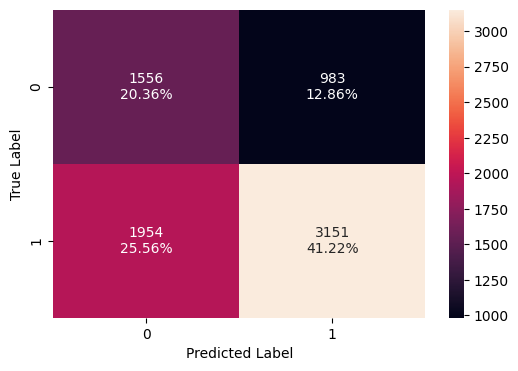

In [124]:
# Test set confusion matrix
plot_confusion_matrix(dt_model_3, X_test, y_test)

In [125]:
# Training set performance
dt_train_perf_3 = model_performance_classification(dt_model_3, X_train_un, y_train_un)
dt_train_perf_3

,Accuracy,Recall,Precision,F1
0,1.0,1.0,1.0,1.0


In [126]:
# Test set performance
dt_test_perf_3 = model_performance_classification(dt_model_3, X_test, y_test)
dt_test_perf_3

,Accuracy,Recall,Precision,F1
0,0.615777,0.617238,0.762216,0.682108


**Observations:**

* Training Performance is perfect across all metrics (Accuracy, Recall, Precision, F1 = 1.0), which indicates severe overfitting on the undersampled data.

* Test Performance is considerably lower with an F1 score of 0.682, accuracy at 61.6%, and recall at 61.7%.

* This large gap shows the model has memorized the small, undersampled training set but fails to generalize on unseen test data.


---



## **2. Bagging Classifier (bag_model_3)**

In [127]:
bag_model_3 = BaggingClassifier(random_state=42)
bag_model_3.fit(X_train_un,y_train_un)

BaggingClassifier(random_state=42)

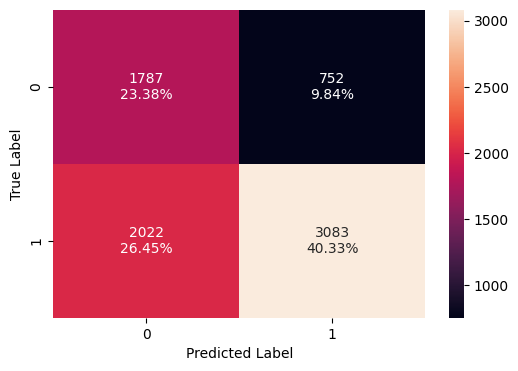

In [128]:
# Test set confusion matrix
plot_confusion_matrix(bag_model_3, X_test, y_test)

In [129]:
# Training set performance
bag_train_perf_3 = model_performance_classification(bag_model_3, X_train_un, y_train_un)
bag_train_perf_3

,Accuracy,Recall,Precision,F1
0,0.978896,0.966909,0.990659,0.97864


In [130]:
# Test set performance
bag_test_perf_3 = model_performance_classification(bag_model_3, X_test, y_test)
bag_test_perf_3

,Accuracy,Recall,Precision,F1
0,0.637101,0.603918,0.803911,0.689709


**Observations:**

* Training performance is nearly perfect (F1 = 0.979), with Recall = 96.7% and Precision = 99%, clearly indicating the model has overfit.

* Test performance drops sharply with F1 score = 0.690, Recall = 60.4%, and Accuracy = 63.7%.

* Overall, the model fails to generalize well and demonstrates poor performance on unseen data.

---



## **3. Random Forest Classifier (rf_model_3)**

In [131]:
rf_model_3 = RandomForestClassifier(random_state=42)
rf_model_3.fit(X_train_un, y_train_un)

RandomForestClassifier(random_state=42)

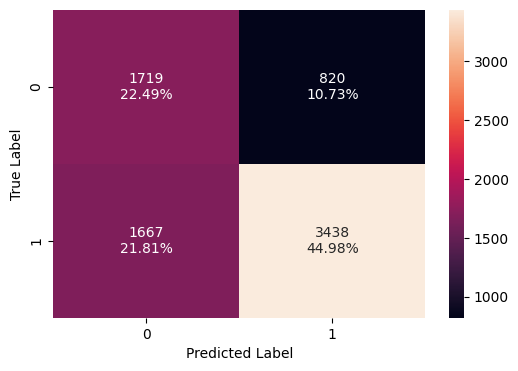

In [132]:
# Test set confusion matrix
plot_confusion_matrix(rf_model_3, X_test, y_test)

In [133]:
# Training set performance
rf_train_perf_3 = model_performance_classification(rf_model_3, X_train_un, y_train_un)
rf_train_perf_3

,Accuracy,Recall,Precision,F1
0,1.0,1.0,1.0,1.0


In [134]:
# Test set performance
rf_test_perf_3 = model_performance_classification(rf_model_3, X_test, y_test)
rf_test_perf_3

,Accuracy,Recall,Precision,F1
0,0.674647,0.673457,0.807421,0.73438


**Observations:**

* The model achieves perfect training performance (F1 = 1.0, Accuracy, Recall, Precision all = 1.0), which indicates severe overfitting on the undersampled training data.

* On the test set, the model delivers a moderate F1 score of 0.734, Recall = 67.3%, and Precision = 80.7%, showing a decent balance but still not optimal.

* The significant drop from train to test scores reflects poor generalization to unseen data.


---



## **4. AdaBoost Classifier (abc_model_3)**

In [135]:
abc_model_3 = AdaBoostClassifier(random_state=42)
abc_model_3.fit(X_train_un,y_train_un)

AdaBoostClassifier(random_state=42)

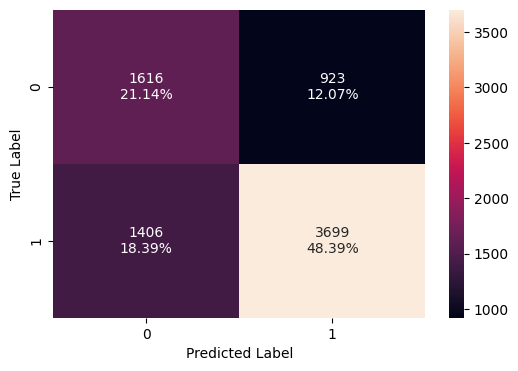

In [136]:
# Test set confusion matrix
plot_confusion_matrix(abc_model_3, X_test, y_test)

In [137]:
# Training set performance
abc_train_perf_3 = model_performance_classification(abc_model_3, X_train_un, y_train_un)
abc_train_perf_3

,Accuracy,Recall,Precision,F1
0,0.692386,0.725815,0.680329,0.702336


In [138]:
# Test set performance
abc_test_perf_3 = model_performance_classification(abc_model_3, X_test, y_test)
abc_test_perf_3

,Accuracy,Recall,Precision,F1
0,0.695317,0.724584,0.800303,0.760563


**Observations:**

* The model shows moderate training performance (F1 = 0.702), with recall at 72.6% and precision around 68%. It avoids overfitting on the undersampled data.

* On the test set, it performs slightly better, achieving an F1 score of 0.761, with high precision (80%) and decent recall (72.5%).

* This train-test performance suggests the model generalizes well, despite the data being undersampled.

* Overall, AdaBoost demonstrates good balance and reliable generalization, making it one of the better-performing models under undersampling.

---




## **5. Gradient Boosting Classifier (gbc_model_3)**

In [139]:
gbc_model_3 = GradientBoostingClassifier(random_state=42)
gbc_model_3.fit(X_train_un,y_train_un)

GradientBoostingClassifier(random_state=42)

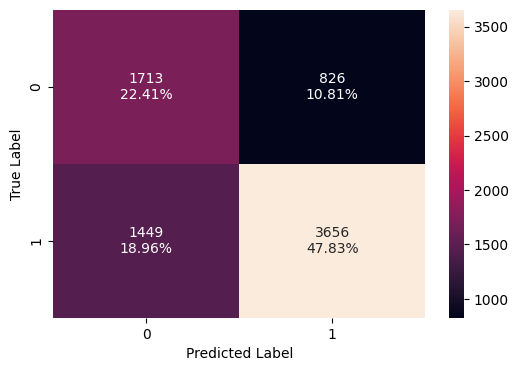

In [140]:
# Test set confusion matrix
plot_confusion_matrix(gbc_model_3, X_test, y_test)

In [141]:
# Training set performance
gbc_train_perf_3 = model_performance_classification(gbc_model_3, X_train_un, y_train_un)
gbc_train_perf_3

,Accuracy,Recall,Precision,F1
0,0.721594,0.731048,0.717481,0.724201


In [142]:
# Test set performance
gbc_test_perf_3 = model_performance_classification(gbc_model_3, X_test, y_test)
gbc_test_perf_3

,Accuracy,Recall,Precision,F1
0,0.702381,0.716161,0.815707,0.762699


**Observations:**

* The model shows balanced training performance with an F1 score of 0.724, recall of 73.1%, and precision around 71.7%, indicating no signs of overfitting.

* On the test set, the performance improves slightly, with an F1 score of 0.763, precision of 81.6%, and recall of 71.6%.

* Overall, the Gradient Boosting model trained on undersampled data generalizes well and delivers a strong balance between precision and recall.

## **Comparing all models (Unbdersampled Data)**

In [143]:
# List of model names and their corresponding train/test DataFrames for undersampled data
models_un = [
    ("Decision Tree", dt_train_perf_3, dt_test_perf_3),
    ("Bagging Classifier", bag_train_perf_3, bag_test_perf_3),
    ("Random Forest Classifier", rf_train_perf_3, rf_test_perf_3),
    ("AdaBoost Classifier", abc_train_perf_3, abc_test_perf_3),
    ("Gradient Boosting Classifier", gbc_train_perf_3, gbc_test_perf_3)
]

# Create a list to store final rows
combined_rows_un = []

# Loop through each model and extract scores
for model_name, train_df, test_df in models_un:
    row_un = {
        'Model': model_name,
        'Train_Accuracy': train_df['Accuracy'][0],
        'Test_Accuracy': test_df['Accuracy'][0],
        'Train_Recall': train_df['Recall'][0],
        'Test_Recall': test_df['Recall'][0],
        'Train_Precision': train_df['Precision'][0],
        'Test_Precision': test_df['Precision'][0],
        'Train_F1': train_df['F1'][0],
        'Test_F1': test_df['F1'][0],
    }
    combined_rows_un.append(row_un)

# Create final comparison DataFrame
comparison_df_un = pd.DataFrame(combined_rows_un)
comparison_df_un

,Model,Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_Precision,Test_Precision,Train_F1,Test_F1
0,Decision Tree,1.000000,0.615777,1.000000,0.617238,1.000000,0.762216,1.000000,0.682108
1,Bagging Classifier,0.978896,0.637101,0.966909,0.603918,0.990659,0.803911,0.978640,0.689709
2,Random Forest Classifier,1.000000,0.674647,1.000000,0.673457,1.000000,0.807421,1.000000,0.734380
3,AdaBoost Classifier,0.692386,0.695317,0.725815,0.724584,0.680329,0.800303,0.702336,0.760563
4,Gradient Boosting Classifier,0.721594,0.702381,0.731048,0.716161,0.717481,0.815707,0.724201,0.762699


### **Key Observations from Undersampled Data Model Building:**

* **Gradient Boosting Classifier** achieved the highest F1 score on the test set (0.763), with good precision (81.6%) and decent recall (71.6%). It generalizes well with minimal overfitting and maintains strong balance between metrics.

* **AdaBoost Classifier** followed closely with a test F1 score of 0.760, showing solid generalization. Performance is stable across training and testing.

* **Random Forest Classifier** had strong test F1 (0.734) and very high training metrics (1.0), indicating clear overfitting.

* **Bagging Classifier** showed a good test F1 score of 0.689, but with significantly higher training performance (0.979), suggesting overfitting and limited generalization.

* **Decision Tree** performed the worst, with a test F1 score of 0.682 and a sharp drop from perfect training metrics. This confirms severe overfitting and poor generalization.



---




## **Models Selected for Hyperparameter Tuning**

Comparing all the models from orginal data, oversampled data and undersampled data, I have selected below 3 models for Hyperparameter Tuning:

**1. Gradient Boosting Classifier (from Original Data)**

* F1 Score: 0.815
* Reason: Best test performance with excellent generalization and low overfitting.

**2. AdaBoost Classifier (from Undersampled Data)**

* F1 Score: 0.760
* Reason: Stable results across datasets, less overfitting, and good recall.

**3. Random Forest Classifier (from Oversampled Data)**

* F1 Score: 0.794
* Reason: High test performance, needs tuning to reduce overfitting.



---



## **Hyperparameter Tuning**

## **1. Gradient Boosting Classifier (from Original Data)**

In [144]:
gbc_tuned = GradientBoostingClassifier(random_state=42)

# Define the parameter grid
parameters = {
    "n_estimators": [100, 150, 200],
    "subsample": [0.8, 0.9, 1.0],
    "max_features": [0.7, 0.8, 0.9, 1.0],
}

# Define the scoring metric
f1_scorer = metrics.make_scorer(metrics.f1_score)

# Set up GridSearchCV
grid_obj = GridSearchCV(estimator=gbc_tuned, param_grid=parameters, scoring=f1_scorer, cv=5)

# Fit on training data
grid_obj.fit(X_train, y_train)

# Best model
gbc_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data.
gbc_tuned.fit(X_train, y_train)

print("Best Parameters:", grid_obj.best_params_)
print("Best F1 Score (CV):", grid_obj.best_score_)

Best Parameters: {'max_features': 0.8, 'n_estimators': 100, 'subsample': 1.0}
Best F1 Score (CV): 0.8197356944042605


In [145]:
# Training set performance
gbc_train_perf_tuned = model_performance_classification(gbc_tuned, X_train, y_train)
gbc_train_perf_tuned

,Accuracy,Recall,Precision,F1
0,0.754093,0.874507,0.782779,0.826104


In [146]:
# Test set performance
gbc_test_perf_tuned = model_performance_classification(gbc_tuned, X_test, y_test)
gbc_test_perf_tuned

,Accuracy,Recall,Precision,F1
0,0.73888,0.866797,0.770772,0.815969


**Observations:**

* The F1 score only improved slightly from 0.815 to 0.816.

* Both recall and precision improved slightly.

* Training metrics are still strong, good sign of generalization.



---



## **3. Random Forest Classifier (from Oversampled Data)**

In [147]:
# Choose the type of classifier.
rf_tuned = RandomForestClassifier(random_state=42)

# Define the parameter grid
parameters_rf = {"n_estimators": [150,200,250],
    "min_samples_leaf": np.arange(5, 10),
    "max_features": np.arange(0.2, 0.7, 0.1),
    "max_samples": np.arange(0.3, 0.7, 0.1),
             }

# Type of scoring used to compare parameter combinations
f1_scorer_abc = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj_rf = GridSearchCV(rf_tuned, parameters_rf, scoring=f1_scorer_abc,cv=5)
grid_obj_rf = grid_obj_rf.fit(X_train_over, y_train_over)

# Set the clf to the best combination of parameters
rf_tuned = grid_obj_rf.best_estimator_

# Fit the best algorithm to the data.
rf_tuned.fit(X_train_over, y_train_over)

RandomForestClassifier(max_features=np.float64(0.2),
                       max_samples=np.float64(0.5),
                       min_samples_leaf=np.int64(6), n_estimators=150,
                       random_state=42)

In [149]:
# Training set performance
rf_train_perf_tuned = model_performance_classification(rf_tuned, X_train_over, y_train_over)
rf_train_perf_tuned

,Accuracy,Recall,Precision,F1
0,0.82326,0.874675,0.793119,0.831903


In [150]:
# Test set performance
rf_test_perf_tuned = model_performance_classification(rf_tuned, X_test, y_test)
rf_test_perf_tuned

,Accuracy,Recall,Precision,F1
0,0.739011,0.857199,0.775611,0.814367


**Observations:**

* The tuning significantly reduces overfitting. Training scores drop to more realistic levels.

* Test F1 score improves from 0.794 to 0.814, showing stronger generalization and better balance between recall and precision.

* Overall, Hyperparameter tuning clearly improved the Random Forest’s performance on unseen data while also addressing overfitting.


---



## **2. AdaBoost Classifier (from Undersampled Data)**

In [151]:
# Choose the type of classifier.
abc_tuned = AdaBoostClassifier(random_state=42)

# Define the parameter grid
parameters_abc = {
    "estimator":[DecisionTreeClassifier(max_depth=1, random_state=42),DecisionTreeClassifier(max_depth=2, random_state=42),DecisionTreeClassifier(max_depth=3, random_state=42)],
    "n_estimators": np.arange(10,110,10),
    "learning_rate":np.arange(0.1,2,0.1)
}

# Type of scoring used to compare parameter combinations
f1_scorer_abc = metrics.make_scorer(metrics.f1_score)

# Run the grid search
grid_obj_abc = GridSearchCV(abc_tuned, parameters_abc, scoring=f1_scorer_abc,cv=5)
grid_obj_abc = grid_obj_abc.fit(X_train_un, y_train_un)

# Set the clf to the best combination of parameters
abc_tuned = grid_obj_abc.best_estimator_

# Fit the best algorithm to the data.
abc_tuned.fit(X_train_un, y_train_un)

print("Best Parameters:", grid_obj_abc.best_params_)
print("Best F1 Score (CV):", grid_obj_abc.best_score_)

Best Parameters: {'estimator': DecisionTreeClassifier(max_depth=2, random_state=42), 'learning_rate': np.float64(0.1), 'n_estimators': np.int64(60)}
Best F1 Score (CV): 0.7139530002478152


In [152]:
# Training set performance
abc_train_perf_tuned = model_performance_classification(abc_tuned, X_train_un, y_train_un)
abc_train_perf_tuned

,Accuracy,Recall,Precision,F1
0,0.700152,0.771906,0.675033,0.720227


In [153]:
# Testing set performance
abc_test_perf_tuned = model_performance_classification(abc_tuned, X_test, y_test)
abc_test_perf_tuned

,Accuracy,Recall,Precision,F1
0,0.7118,0.764936,0.79564,0.779986


**Observations:**

* F1 Score (Test) improved to 0.779, up from the original 0.760.

* The model now shows better generalization, with balanced precision (79.5%) and recall (76.5%) on test data.



---



## **Comparing all models (Tuned models)**

In [154]:
# List of model names and their corresponding train/test DataFrames for tuned models
models_tuned = [
    ("Random Forest Classifier", rf_train_perf_tuned, rf_test_perf_tuned),
    ("AdaBoost Classifier", abc_train_perf_tuned, abc_test_perf_tuned),
    ("Gradient Boosting Classifier", gbc_train_perf_tuned,gbc_test_perf_tuned )
]

# Create a list to store final rows
combined_rows_tuned = []

# Loop through each model and extract scores
for model_name, train_df, test_df in models_tuned:
    row_tuned = {
        'Model': model_name,
        'Train_Accuracy': train_df['Accuracy'][0],
        'Test_Accuracy': test_df['Accuracy'][0],
        'Train_Recall': train_df['Recall'][0],
        'Test_Recall': test_df['Recall'][0],
        'Train_Precision': train_df['Precision'][0],
        'Test_Precision': test_df['Precision'][0],
        'Train_F1': train_df['F1'][0],
        'Test_F1': test_df['F1'][0],
    }
    combined_rows_tuned.append(row_tuned)

# Create final comparison DataFrame
comparison_df_tuned = pd.DataFrame(combined_rows_tuned)
comparison_df_tuned

,Model,Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_Precision,Test_Precision,Train_F1,Test_F1
0,Random Forest Classifier,0.823260,0.739011,0.874675,0.857199,0.793119,0.775611,0.831903,0.814367
1,AdaBoost Classifier,0.700152,0.711800,0.771906,0.764936,0.675033,0.795640,0.720227,0.779986
2,Gradient Boosting Classifier,0.754093,0.738880,0.874507,0.866797,0.782779,0.770772,0.826104,0.815969


## **Final Model Selection:**

* Among the hyperparameter-tuned models, the **Gradient Boosting Classifier** emerged as the best overall performing model, achieving the highest test F1 score (0.816) along with excellent recall (86.7%) and precision (77.1%). It generalizes well with minimal overfitting, making it highly reliable for balanced classification tasks.

* The **Random Forest Classifier** also performed exceptionally well after tuning, with a test F1 score of 0.814 and slightly higher recall (85.7%) than GBC. Although its training performance is slightly higher, the gap between train and test metrics has narrowed, indicating improved generalization.

* Lastly, the **AdaBoost Classifier**, while slightly behind in F1 score (0.780), still offers solid performance with balanced precision and recall.

* Overall, all three tuned models show strong potential, **with Hypertuned Gradient Boosting (Original Data) being the most balanced and effective for deployment.**



---



## **Insights and Recommendations:**

After evaluating multiple classification models across original, oversampled, and undersampled datasets, the following insights and conclusions are drawn:

* The final selected model Gradient Boosting can help the organization automate visa application screening, reducing manual workload and increasing efficiency. With high recall values, the chosen model is well-suited to minimize false negatives, ensuring that deserving candidates are not wrongly rejected.

* The feature importance output reveals that the model relies most heavily on the following variables: education_of_employee, prevailing_wage, age_company, and no_of_employees. These features play a key role in determining the visa case status and are strong indicators for prediction.

* The models can be deployed as part of an internal decision support system to prioritize approvals or rejections, improving processing speed and fairness.

#### **Thank You !**

---

